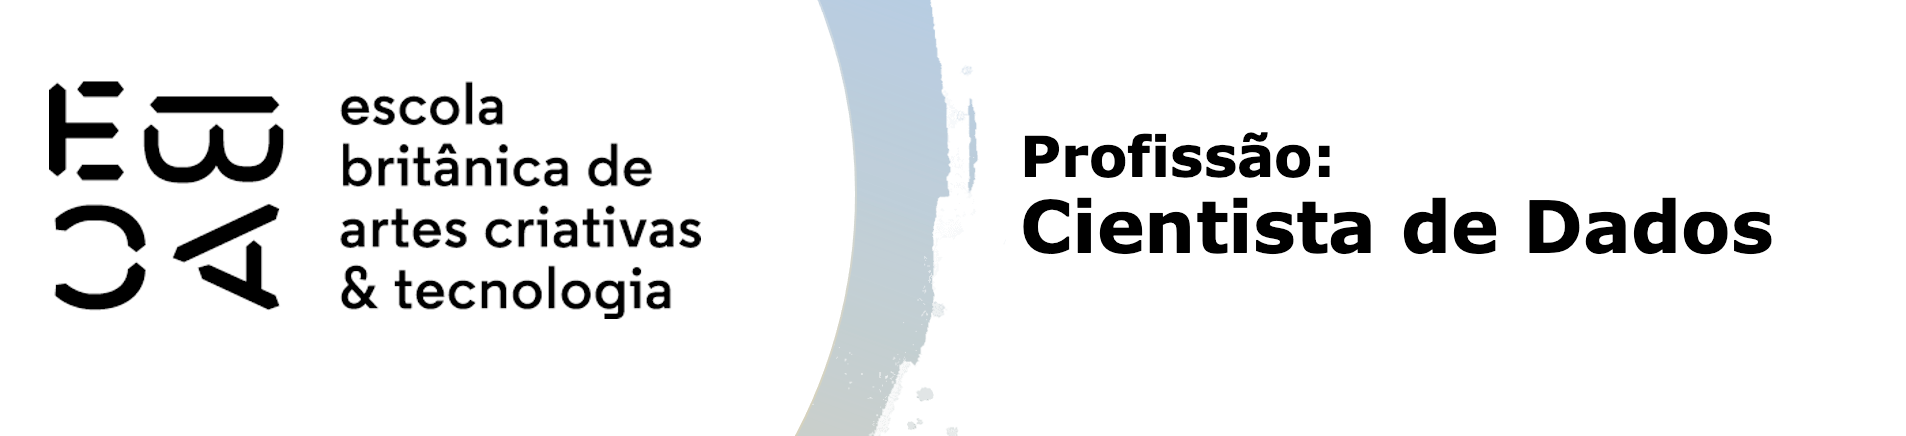

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pyplt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import pickle
import os
import patsy
import pingouin as pg
import warnings
from datetime import timedelta
from statsmodels.stats.outliers_influence import OLSInfluence as olsi
from statsmodels.graphics.gofplots import qqline
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.graphics.regressionplots import plot_partregress_grid
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
# função para fazer cache de alguns gráficos
def cache_function(fnc, arquivo):
    objeto = None
    arquivo = arquivo + '.pickle'
    try:
        with open(arquivo, 'rb') as f:
            objeto = pickle.load(f)
    except FileNotFoundError:
        objeto = fnc()
        with open(arquivo, 'wb') as f:
            pickle.dump(objeto, f)
    return objeto

In [3]:
df = pd.read_csv('previsao_de_renda_II.csv', parse_dates=['data_ref'])

In [4]:
# Verificando que a base de dados possui a coluna 'tempo_emprego' com dados faltantes para o 'tipo_renda' Pensionista

list(df[df['tempo_emprego'].isna()]['tipo_renda'].unique())

['Pensionista']

In [5]:
# Função que será usada abaixo para preencher os dados faltantes do 'tempo_emprego'
# com a média do tempo de emprego de quem possui 'tipo_renda' igual a Pensionista como verificado acima

def preencher_na(fr: pd.DataFrame):
    media = fr.query('tipo_renda == "Pensionista"')['tempo_emprego'].mean()
    return fr.fillna(value={'tempo_emprego' : media})

In [6]:
# Função que será usada para categorizar os registros pelo tempo de emprego em 20 quartis (faixas)

def categorizar_tempo(fr: pd.DataFrame):
    tempo = pd.qcut(x=fr['tempo_emprego'], q=20, duplicates='drop', precision=4)
    fr['tempo_emprego_cat'] = pd.Categorical(tempo)    
    return fr

In [7]:
# Função que será usada para categorizar os registros por uma faixa de tempo
# Aqui crio um critério diferente dos 20 quartis para categorizar o tempo de emprego
# Discordo de preencher o tempo de emprego do pensionista com a média
# Pensionista em si não deveria ter tempo de emprego considerado, talvez por isso que originalmente estava Null 
# No caso dessa coluna, será criada uma categoria de tempo 99 para indicar que se trata de pensionista
# Essa coluna será usada para testes 

def categorizar_faixa_tempo(fr: pd.DataFrame):
    # cria um series com o tempo em inteiro
    tempo_series = np.round(fr['tempo_emprego'], 0)
    
    # recupera o maior e menor tempo e define o intervalo como o maior / 20
    tempo = tempo_series.describe()
    passo = tempo['max'] / 20
    ini = tempo['min']
    
    valores = []
    while (ini < tempo['max']):
        fim = np.round(ini + passo + 0.01, 2)
        valores.append(pd.Interval(left=ini, right=fim, closed='left'))
        ini = fim

    fr['tempo_emprego_int'] = tempo_series

    def aplicar_faixa(x):
        for faixa in valores:
            if x in faixa:
                return faixa
        return None

    fr['tempo_emprego_faixa'] = fr['tempo_emprego_int'].apply(aplicar_faixa)
    fr.drop(columns=['tempo_emprego_int'], inplace=True)

    # para quem é Pensionista, será criada uma faixa de tempo "fake" cujo valor é 99
    # indicando que se trata de Pensionista
    index = fr.query('tipo_renda=="Pensionista"').index
    fr.loc[index, 'tempo_emprego_faixa'] = pd.Interval(left=99, right=99, closed='both')
    
    fr['tempo_emprego_faixa'] = pd.Categorical(fr['tempo_emprego_faixa'])
    return fr

In [8]:
# Função para categorizar as variáveis

def categorizar_variaveis(fr: pd.DataFrame):
    fr['sexo'] = pd.Categorical(fr['sexo'])
    fr['posse_de_veiculo'] = pd.Categorical(fr['posse_de_veiculo'])
    fr['posse_de_imovel'] = pd.Categorical(fr['posse_de_imovel'])
    fr['tipo_renda'] = pd.Categorical(fr['tipo_renda'])
    fr['educacao'] = pd.Categorical(fr['educacao'])
    fr['estado_civil'] = pd.Categorical(fr['estado_civil'])
    fr['tipo_residencia'] = pd.Categorical(fr['tipo_residencia'])
    return fr

In [9]:
# Rodando todas as transformações nos dados do Dataframe

df = (
    # remove a coluna index
    df.drop(columns=['index'])
    
    # Preenche os dados faltantes
    .pipe(preencher_na)
    
    # categorizando por tempo de emprego
    .pipe(categorizar_tempo)
    
    # categorizando por faixa de tempo. Semelhante ao passo dos quartis, mas com outro critério
    .pipe(categorizar_faixa_tempo)
    
    # categorizar variáveis
    .pipe(categorizar_variaveis)
    
    # cria uma coluna com o log da renda (Y)
    .assign(renda_log = lambda x: np.log(x['renda']))
)

In [10]:
df.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,tempo_emprego_faixa,renda_log
0,2015-01-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.2164, 20.2164]","[15.12, 17.28)",9.318131
1,2015-01-01,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.0932, 10.4384]","[8.64, 10.8)",7.793508
2,2015-01-01,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.1068, 9.0932]","[6.48, 8.64)",9.528769
3,2015-01-01,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.8164, 1.4575]","[0.0, 2.16)",7.767196
4,2015-01-01,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.8164, 1.4575]","[0.0, 2.16)",6.673020


In [11]:
# O código abaixo lista o valor mais frequente para cada variável categórica
# esse valor será usado como casela de referência

for col in df.select_dtypes(include=['object', 'category']).columns:
    maior_valor = df[col].value_counts().sort_values(ascending=False).index[0]
    print(f"Coluna {col}: {maior_valor}")

Coluna sexo: F
Coluna posse_de_veiculo: N
Coluna posse_de_imovel: S
Coluna tipo_renda: Assalariado
Coluna educacao: Médio
Coluna estado_civil: Casado
Coluna tipo_residencia: Casa
Coluna tempo_emprego_cat: (6.6219, 6.9873]
Coluna tempo_emprego_faixa: [0.0, 2.16)


In [12]:
variaveis_modelo = [
    "C(sexo, Treatment('F'))",
    "C(posse_de_veiculo, Treatment('N'))",
    "C(posse_de_imovel, Treatment('S'))",
    "C(tipo_renda, Treatment('Assalariado'))",
    "C(educacao, Treatment('Médio'))",
    "C(estado_civil, Treatment('Casado'))",
    "C(tipo_residencia, Treatment('Casa'))",
    "idade",
    "qtd_filhos",
    "qt_pessoas_residencia",
    "tempo_emprego_cat"
]

In [13]:
# Separando os dados de X e Y de acordo com a configuração de variáveis acima

y, X = patsy.dmatrices(f"renda_log ~ {' + '.join(variaveis_modelo)}", df, return_type='dataframe')

In [14]:
# Separando o Dataframe principal em 2. Os registros dos últimos 3 meses serão os dados de teste

data_corte = df.data_ref.max() - timedelta(days=3*30)
df_teste  = df.query('data_ref >= @data_corte')
df_treino = df.query('data_ref  < @data_corte')

In [15]:
# Criando as variáveis de treino e teste: X_train, y_train, X_test e y_test
# Essas variáveis aqui são um Dataframe do pandas

X_test = X.iloc[df_teste.index]
y_test = y.iloc[df_teste.index]

X_train = X.iloc[df_treino.index]
y_train = y.iloc[df_treino.index]

In [16]:
# Convertendo as variáveis de treino e teste em objetos do tipo DesignMatrix do patsy para serem usadas no statsmodels
# Sei que não seria necessário tudo isso, mas fiz assim mesmo para aprender algo diferente

X_test = patsy.DesignMatrix(X_test, X.design_info)
y_test = patsy.DesignMatrix(y_test, y.design_info) 

X_train = patsy.DesignMatrix(X_train, X.design_info)
y_train = patsy.DesignMatrix(y_train, y.design_info) 

In [17]:
# Treinando o modelo com todas as variáveis exceto data_ref e index

reg = sm.OLS(y_train, X_train).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                 1.117e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:38:06   Log-Likelihood:            -8.0321e+05
No. Observations:              600000   AIC:                         1.606e+06
Df Residuals:                  599959   BIC:                         1.607e+06
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           7.7791      0.046    168.402      0.000       7.689       7.870
C(sexo, Treatment('F'))[T.M]                                        0.1306      0.003     46.339      0.000       0.125       0.136
C(posse_de_veiculo, Treatment('N'))[T.S]                            0.0087      0.003      3.247      0.001       0.003       0.014
C(posse_de_imovel, Treatment('S'))[T.N]                            -0.1776      0.003    -67.664      0.000      -0.183      -0.172
C(tipo_renda, Treatment('Assalariado'))[T.Bolsista]                -0.2906      0.053     -5.461      0.000      -0.395      -0.186
C(tipo_renda, Treatment('Assalariado'))[T.Empresário]               0.1382      0.003     45.702      0.000       0.132       0.144
C(tipo_renda, Treatment('Assalariado'))[T.Pensionista]             -0.1726      0.009    -20.191      0.000      -0.189      -0.156
C(tipo_renda, Treatment('Assalariado'))[T.Servidor público]         0.1352      0.004     30.355      0.000       0.127       0.144
C(educacao, Treatment('Médio'))[T.Fundamental]                     -0.0300      0.011     -2.650      0.008      -0.052      -0.008
C(educacao, Treatment('Médio'))[T.Pós graduação]                    0.0997      0.037      2.701      0.007       0.027       0.172
C(educacao, Treatment('Médio'))[T.Superior completo]                0.0946      0.003     35.808      0.000       0.089       0.100
C(educacao, Treatment('Médio'))[T.Superior incompleto]              0.0146      0.006      2.315      0.021       0.002       0.027
C(estado_civil, Treatment('Casado'))[T.Separado]                    0.1631      0.023      7.019      0.000       0.118       0.209
C(estado_civil, Treatment('Casado'))[T.Solteiro]                    0.1684      0.023      7.383      0.000       0.124       0.213
C(estado_civil, Treatment('Casado'))[T.União]                       0.0038      0.005      0.835      0.403      -0.005       0.013
C(estado_civil, Treatment('Casado'))[T.Viúvo]                       0.1577      0.023      6.715      0.000       0.112       0.204
C(tipo_residencia, Treatment('Casa'))[T.Aluguel]                    0.0877      0.010      8.507      0.000       0.067       0.108
C(tipo_residencia, Treatment('Casa'))[T.Com os pais]                0.0266      0.006      4.429      0.000       0.015       0.038
C(tipo_residencia, Treatment('Casa'))[T.Comunitário]               -0.1051      0.018     -5.775      0.000      -0.141      -0.069
C(tipo_residencia, Treatment('Casa'))[T.Estúdio]                   -0.0427      0.014     -3.017      0.003      -0.070      -0.015
C(tipo_residencia, Treatment('Casa'))[T.Governa

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

O modelo com todas as variáveis possui um R<sup>2</sup> de 0.427
    
</div>

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

### Verificando a distribuição normal do modelo

In [18]:
plt.rc("figure", figsize=(16, 8))

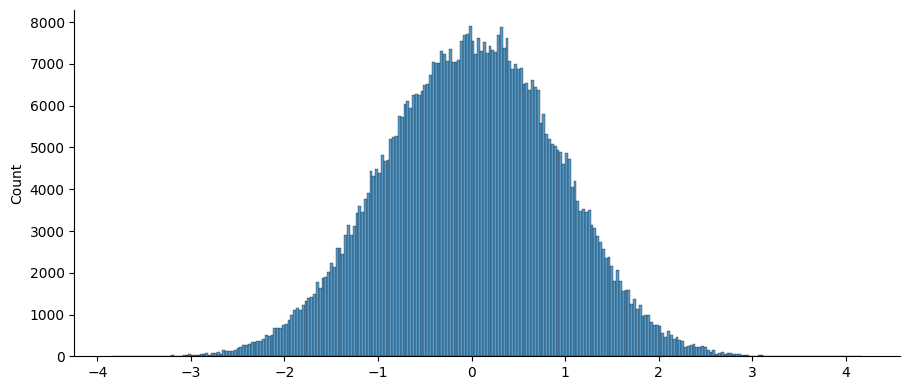

In [19]:
sns.displot(reg.resid, height=4, aspect=2.3);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

O gráfico de distribuição dos resíduos mostra uma distribuição aproximadamente normal, com a maioria dos pontos concentrados próximos da linha central. No entanto, existem alguns pontos discrepantes (outliers) que se distanciam significativamente da média.
    
</div>

### Gráfico dos resíduos versus os valores preditos

In [20]:
preditos = reg.predict()

In [21]:
regsi = olsi(reg)

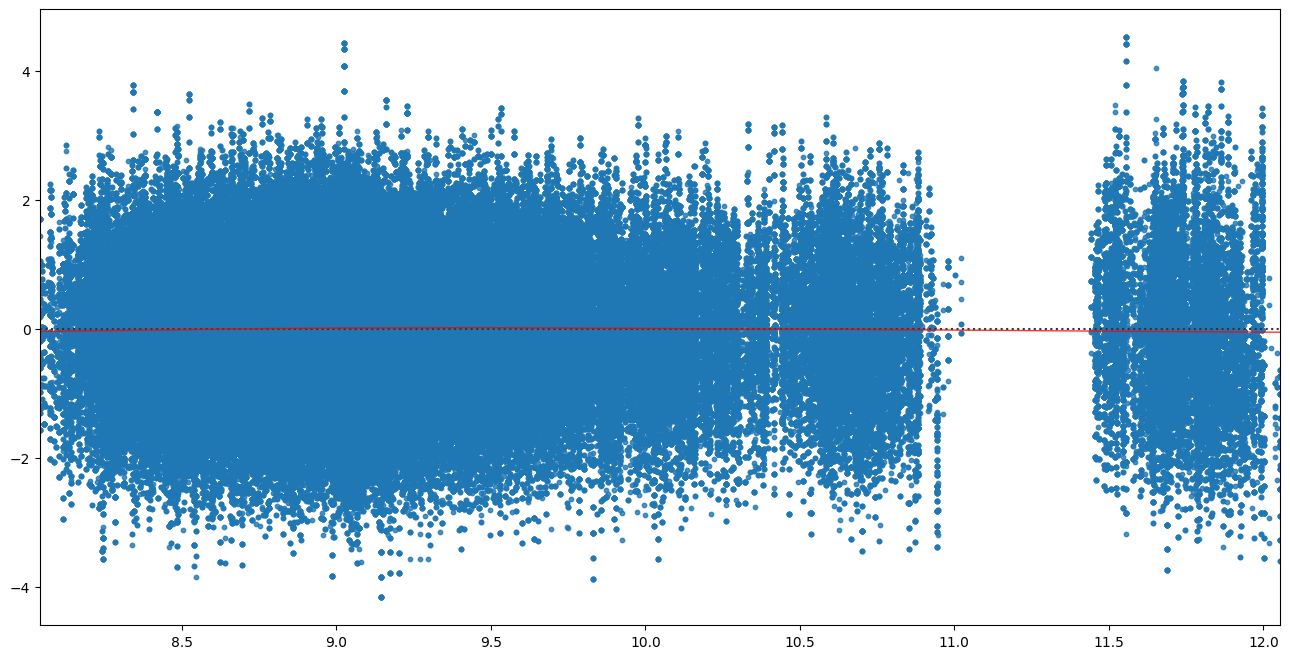

In [22]:
def residplot01():
    return sns.residplot(
        x=preditos,
        y=regsi.resid_studentized, 
        lowess=True,
        scatter_kws={'alpha': 0.8, 's': 10}, 
        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
    );
cache_function(residplot01, 'residplot01');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

No gráfico podemos ver um padrão em forma de "V", indicando a presença de heterocedasticidade. Esse padrão pode ser observado na parte inferior do gráfico, por exemplo, próximo ao valor 9 no eixo X, onde os valores preditos são menores, estão mais próximos da linha horizontal. Isso indica que os resíduos para esses valores preditos são menores e mais homogêneos.
    
    
O gráfico também apresenta um sutil padrão curvilíneo. Na parte superior, por exemplo, poderíamos traçar uma curva iniciando em 8 no eixo X, que subiria até 9, depois cairia até 10.4 quando então voltaria a subir até o final.
</div>

### Avaliar se há padrões dos resíduos versus cada uma das variáveis do modelo

In [23]:
# função para criar um gráfico dos resíduos para as variáveis categóricas
def cat_residplot(cat:str):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        # gráfico dos resíduos
        g = sns.residplot(
            x=df_treino[cat].cat.codes,
            y=regsi.resid_studentized, 
            lowess=True,
            scatter_kws={'alpha': 0.8, 's': 20}, 
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
        );

        # recupera o código das categorias
        gcodes = list(np.unique(df_treino[cat].cat.codes));

        # define no eixo X apenas os códigos das categorias
        g.set_xticks(gcodes);

        # faz um "padding" no gráfico nas laterais
        pyplt.xlim((min(gcodes)-1), (max(gcodes)+1));

        # cria um texto para a legenda com os valores das categorias
        legenda = []
        categories = df_treino[cat].cat.categories
        for c in gcodes:
            legenda.append(f'({c}) {categories[c]}')
        legenda = '  '.join(legenda)

        # imprime a legenda
        g.text(0.5, -5.5, legenda, ha='center', va='bottom');

#### Idade

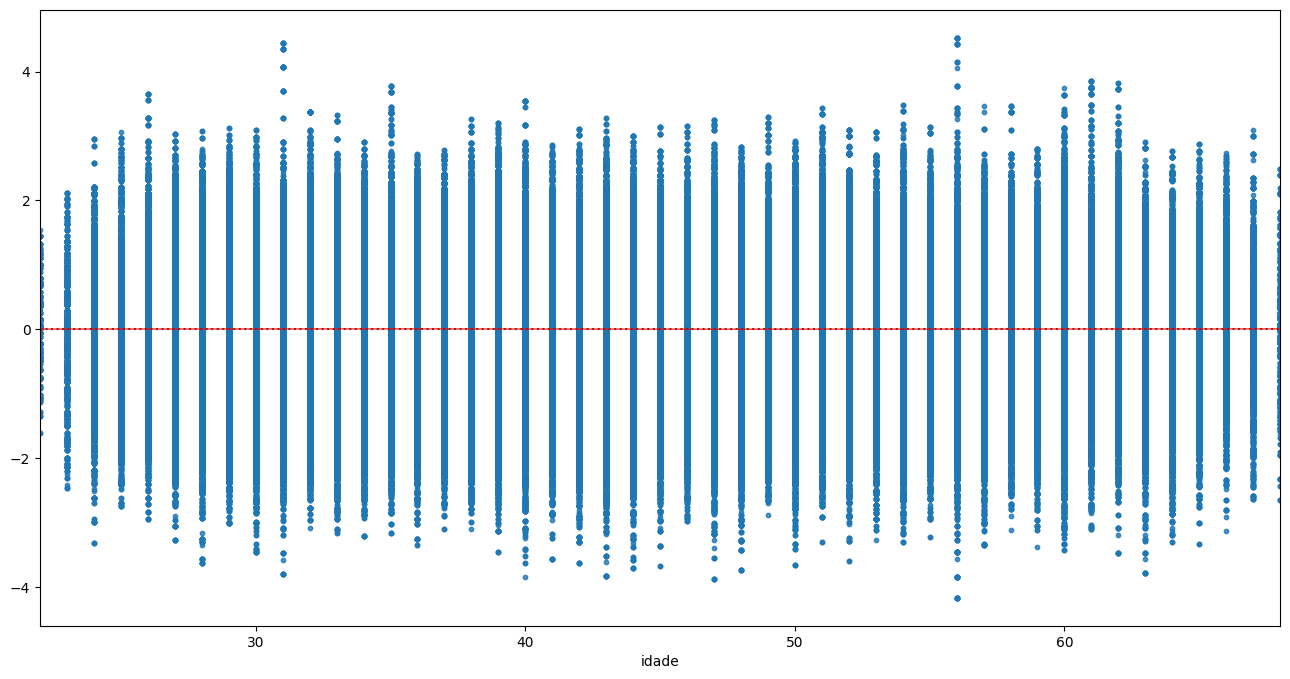

In [24]:
sns.residplot(
    x='idade',
    y=regsi.resid_studentized, 
    data=df_treino, 
    lowess=True,
    scatter_kws={'alpha': 0.8, 's': 10}, 
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A maioria dos pontos está concentrada em torno da linha horizontal zero, indicando que os resíduos estão centrados em zero, o que é um bom sinal. No entanto, há alguns pontos discrepantes (outliers) que se distanciam significativamente da linha central.
</div>

#### Qtd. pessoas residencia


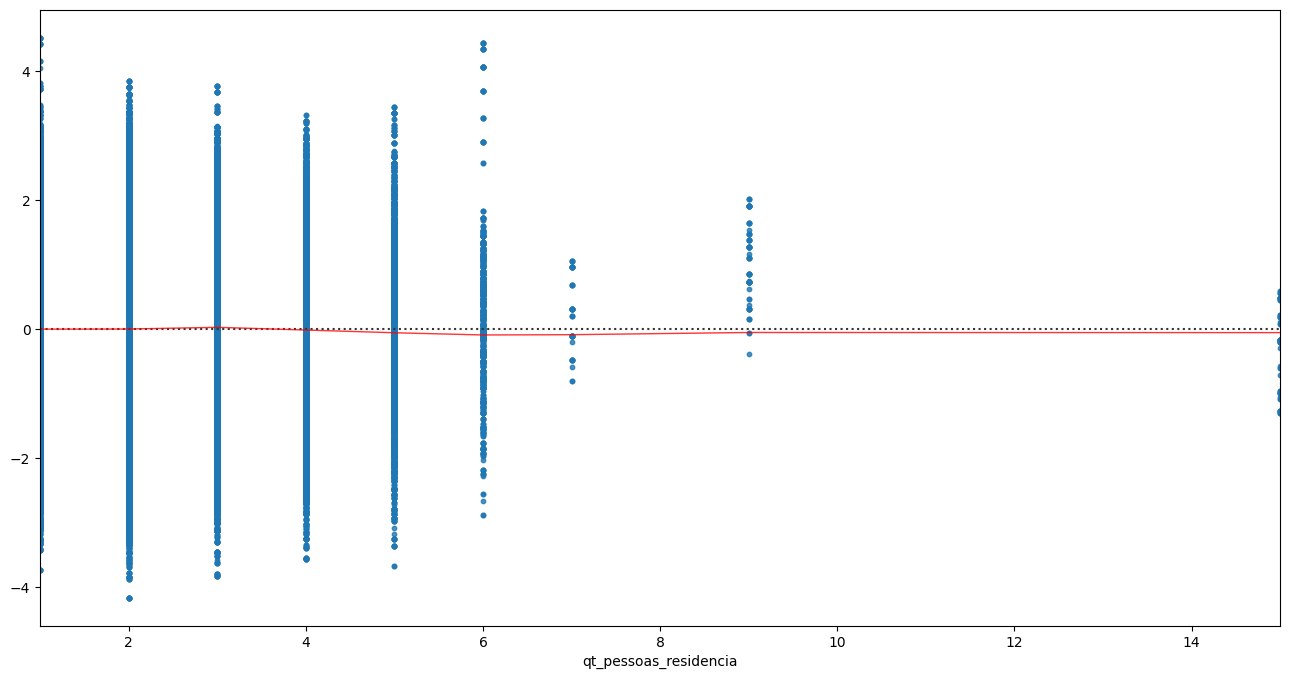

In [25]:
sns.residplot(
    x='qt_pessoas_residencia',
    y=regsi.resid_studentized, 
    data=df_treino, 
    lowess=True,
    scatter_kws={'alpha': 0.8, 's': 10}, 
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

O gráfico mostra uma relação linear negativa entre os resíduos do modelo de regressão e a quantidade de pessoas que moram na mesma residência. Isso significa que, para cada pessoa adicional que mora na residência, os resíduos do modelo de regressão diminuem em média em uma quantidade específica.
</div>

#### Sexo

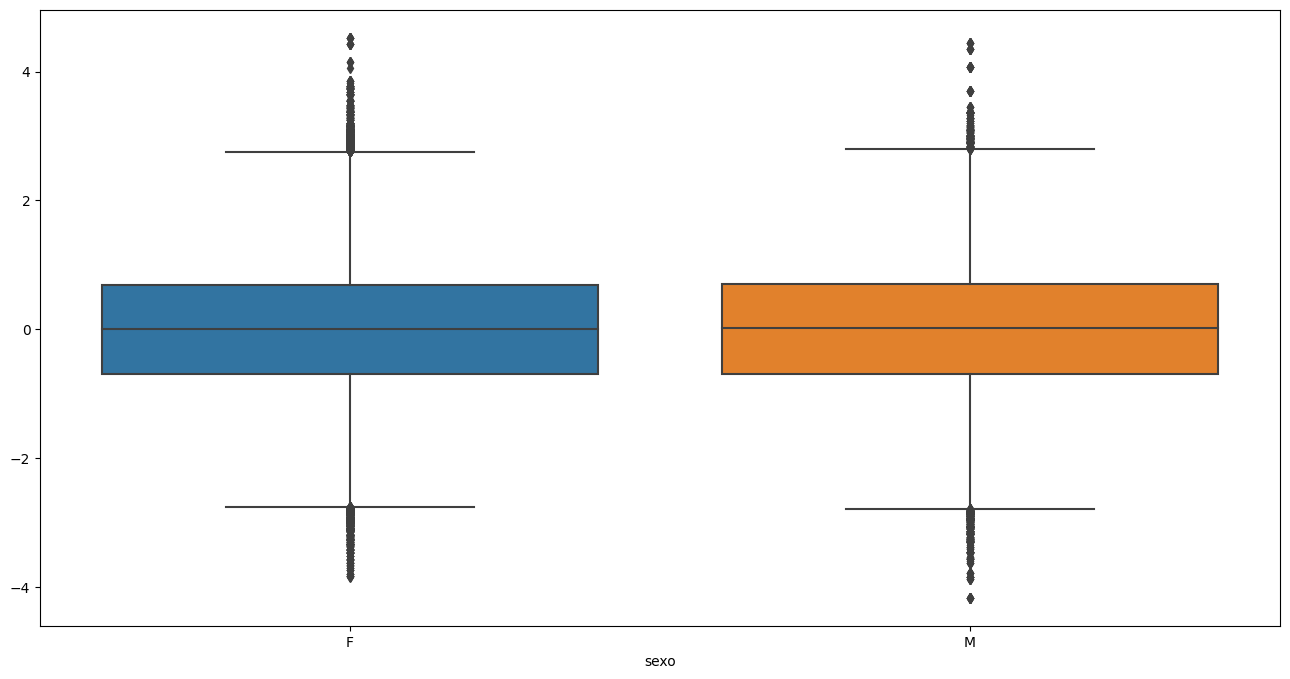

In [26]:
sns.boxplot(data=df_treino, x="sexo", y=regsi.resid_studentized);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

O histograma dos resíduos contra a variável categórica sexo, homens e mulheres, parece não apresentar nenhum padrão óbvio. A distribuição dos resíduos para ambos os sexos parece ser simétrica e normal, com a maioria dos resíduos concentrados em torno de zero. No entanto, existem alguns pontos que podem ser considerados outliers.
</div>

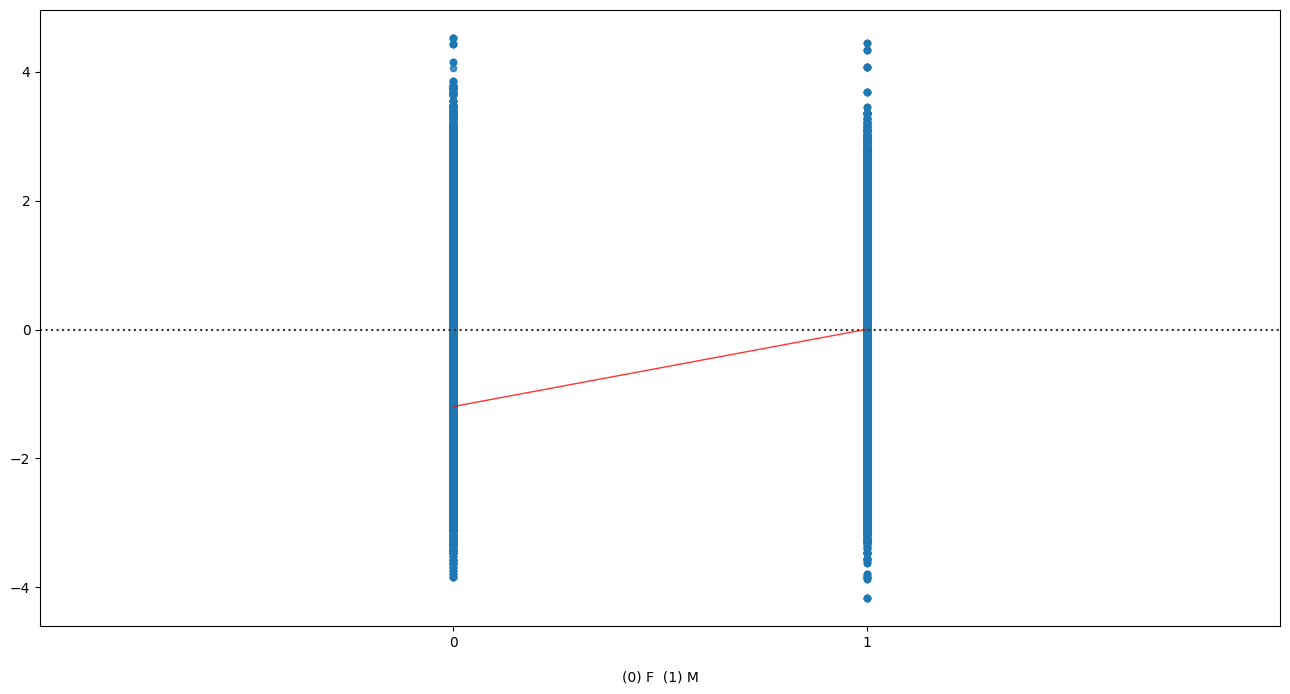

In [27]:
cat_residplot('sexo')

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Existe uma relação entre a variável "sexo" e os resíduos da regressão linear. Essa relação é curvilínea, o que significa que o efeito do sexo sobre os resíduos varia de acordo com o valor da variável.
</div>

#### Posse de veículo e posse de imóvel

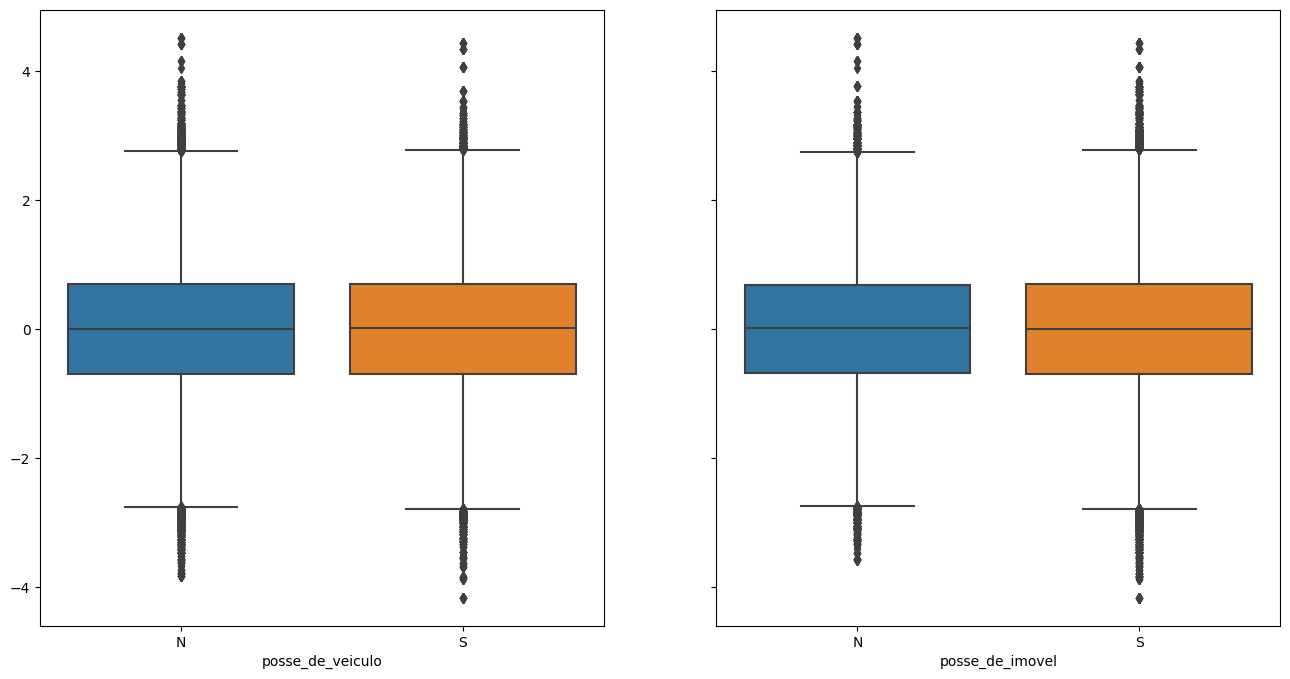

In [28]:
fig, axes = pyplt.subplots(1, 2, sharey=True)
sns.boxplot(ax=axes[0], data=df_treino, x="posse_de_veiculo", y=regsi.resid_studentized);
sns.boxplot(ax=axes[1], data=df_treino, x="posse_de_imovel",  y=regsi.resid_studentized);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

O histograma dos resíduos contra as variáveis posse de veículo e posse de imóvel, parece não apresentar nenhum padrão óbvio. A distribuição dos resíduos parece ser simétrica e normal, com a maioria dos resíduos concentrados em torno de zero. No entanto, existem alguns pontos que podem ser considerados outliers.
</div>

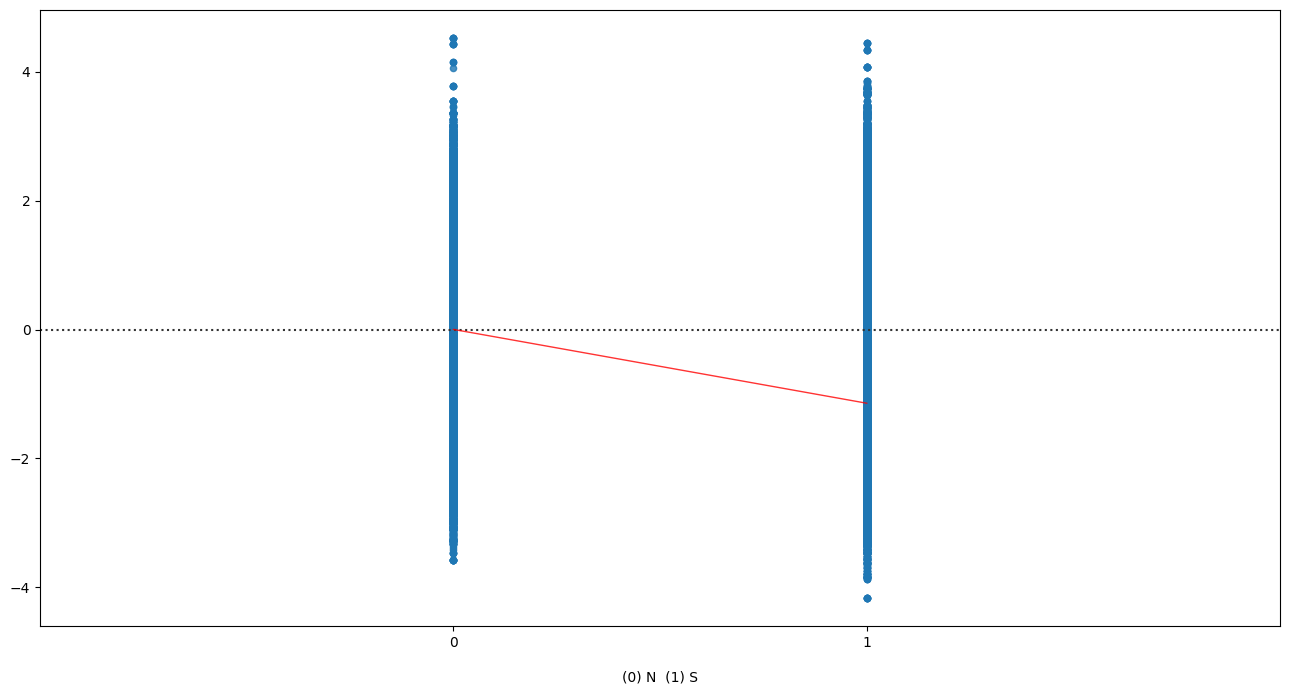

In [29]:
cat_residplot('posse_de_imovel')

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Existe uma relação entre a variável "posse_de_imovel" e os resíduos da regressão linear. Essa relação pode indicar que existe um efeito do posso de imóvel sobre os resíduos.
</div>

#### Tipo de renda

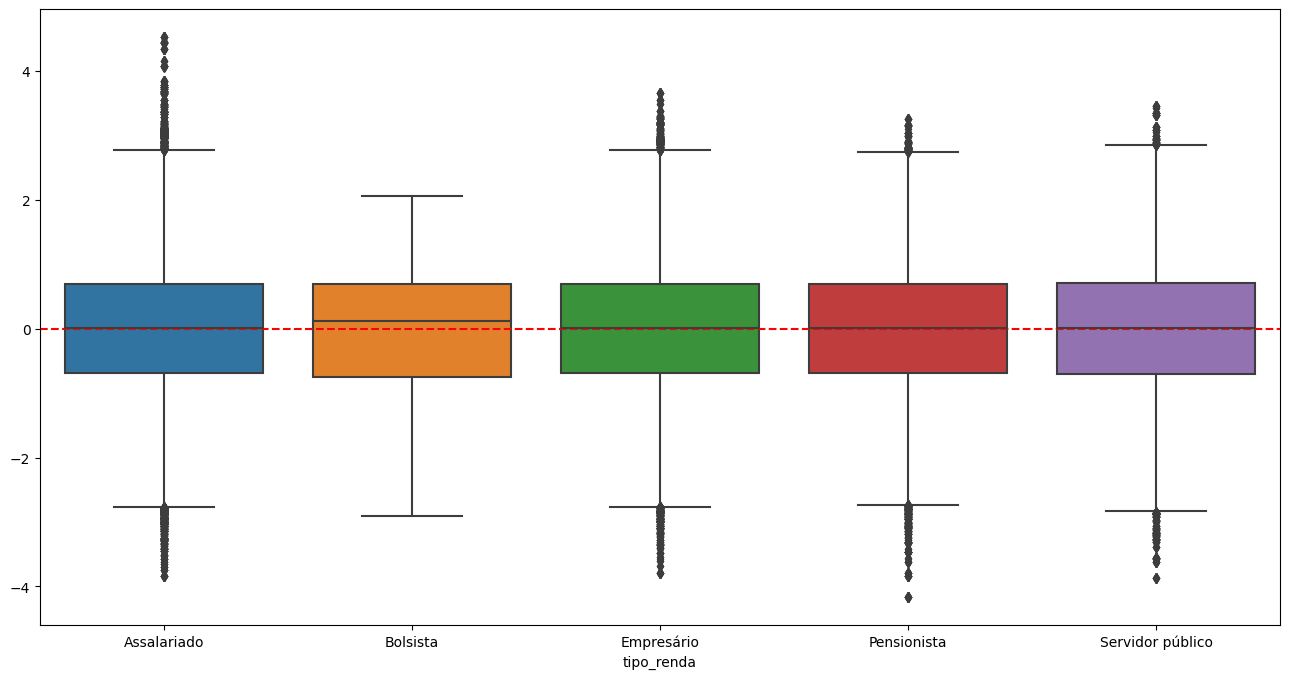

In [30]:
ax = sns.boxplot(data=df_treino, x="tipo_renda", y=regsi.resid_studentized);
ax.axhline(y=0, color="red", linestyle='--');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A mediana dos resíduos é próxima de zero para todos os tipos de renda (exceto para Bolsista) indicando que o modelo de regressão não está subestimando ou superestimando significativamente os valores da variável dependente para nenhum tipo de renda.

A dispersão dos resíduos é maior para os tipos de renda "Assalariado" e "Empresário", indicando que o modelo de regressão é menos preciso para esses tipos de renda.
    
Há alguns outliers para os tipos de renda "Assalariado" e "Pensionista", indicando que o modelo de regressão pode não ser adequado para esses tipos de renda.
</div>

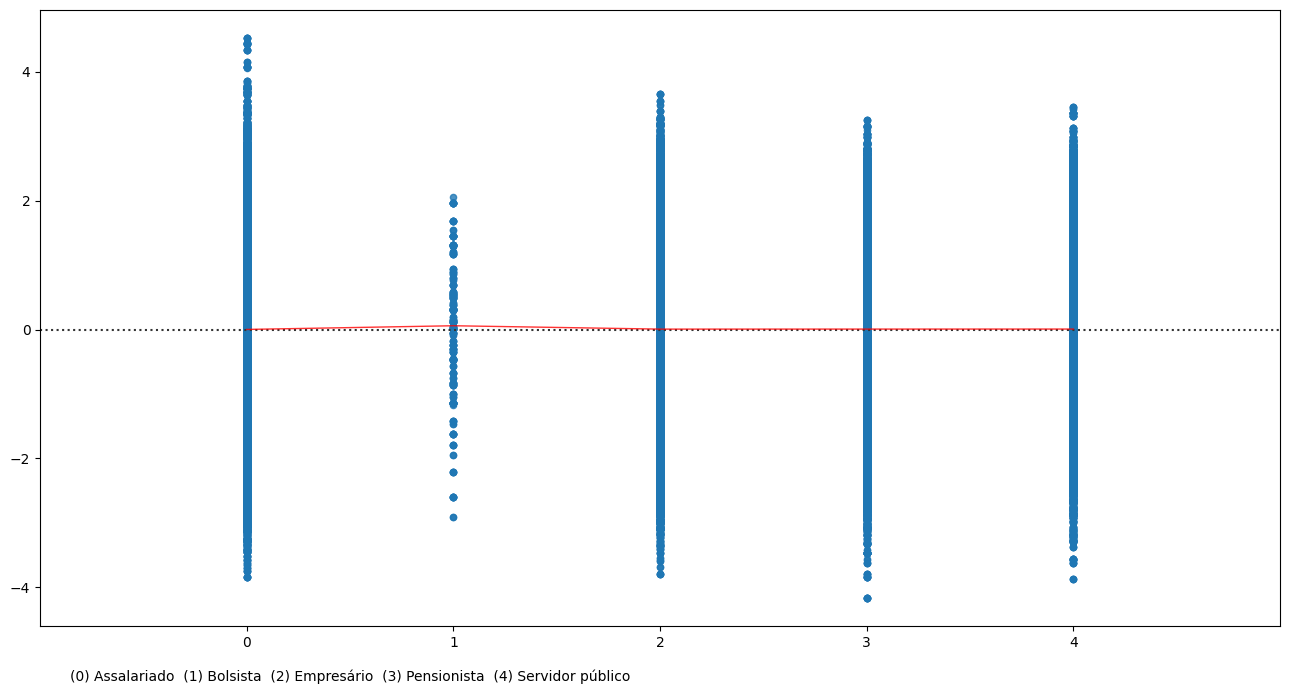

In [31]:
cat_residplot('tipo_renda')

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

De acordo com o gráfico dos resíduos acima, também podemos observar um padrão para o tipo de renda "Bolsista"
</div>

#### Educação

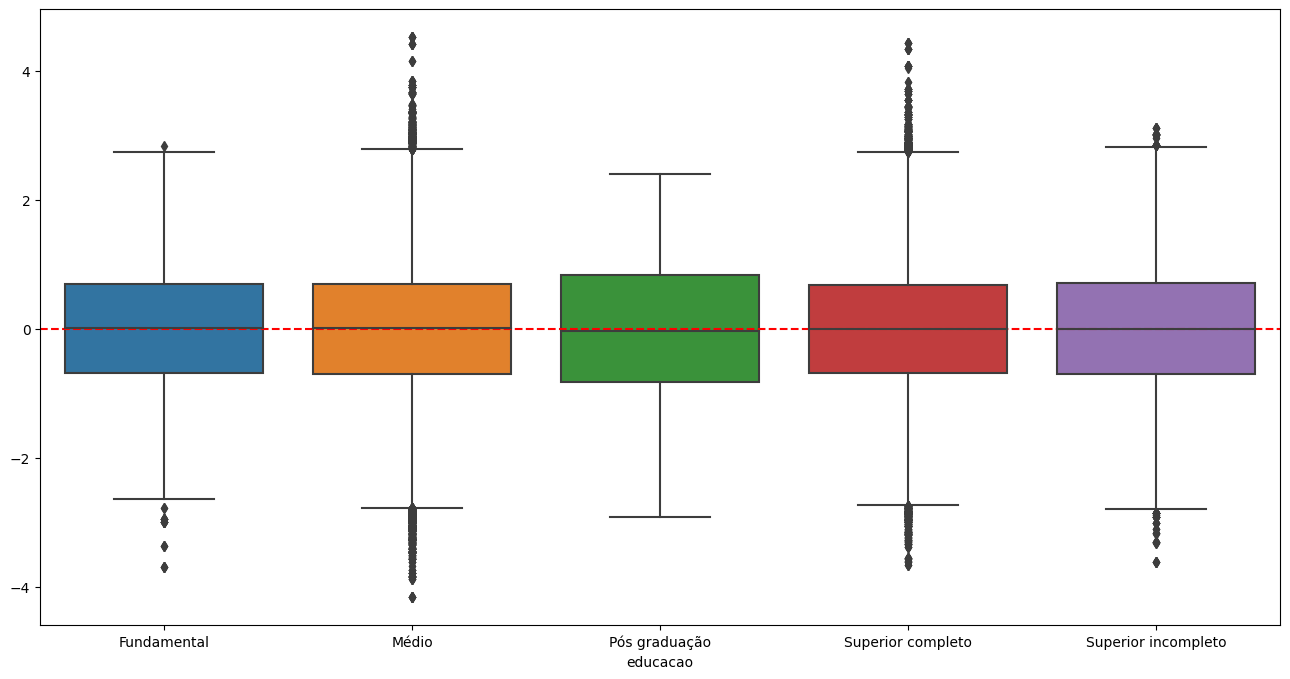

In [32]:
ax = sns.boxplot(data=df_treino, x="educacao", y=regsi.resid_studentized);
ax.axhline(y=0, color="red", linestyle='--');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A mediana dos resíduos está próxima de zero para todos os níveis educacionais, o que indica que o modelo de regressão linear está ajustado de forma adequada em geral. Mas a variabilidade dos resíduos parece ser diferente para os diferentes níveis educacionais. Isso pode indicar heterocedasticidade, que é um problema que pode afetar a confiabilidade dos resultados da regressão linear.
    
Existem alguns outliers, especialmente para os níveis "Médio" e "Superior completo". Isso pode indicar que esses pontos não se encaixam no modelo de regressão linear.
</div>

#### Estado civil

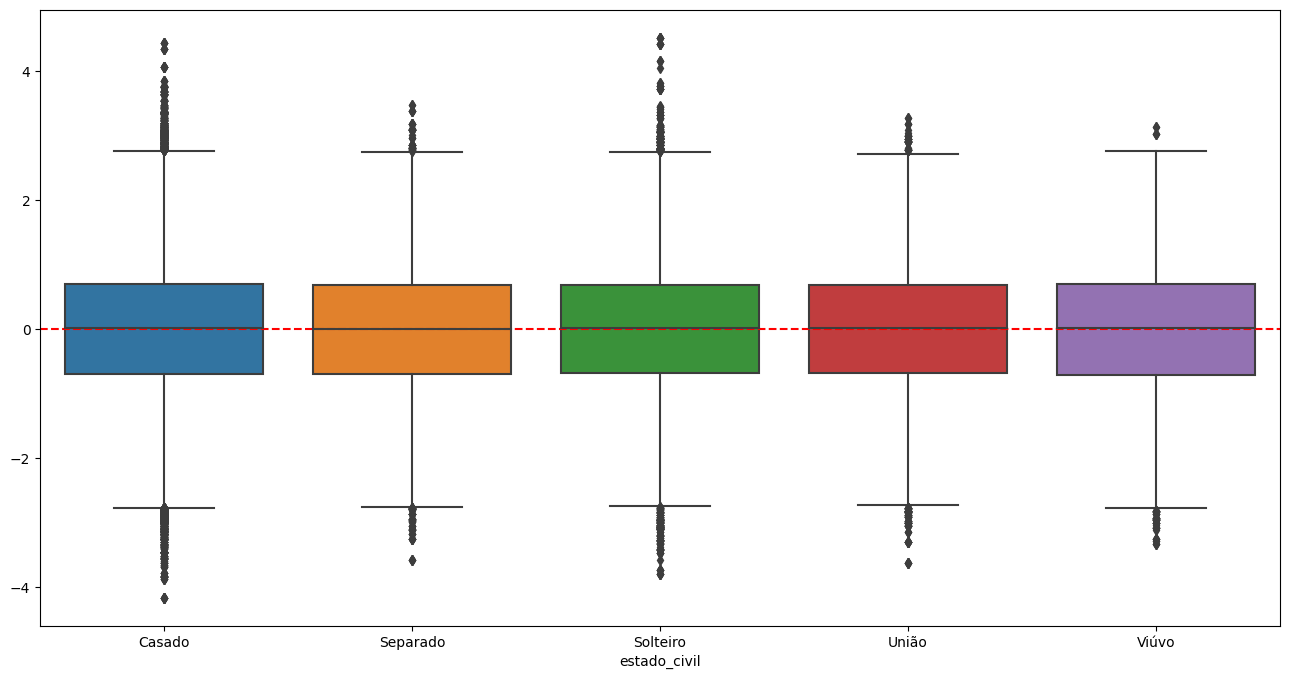

In [33]:
ax = sns.boxplot(data=df_treino, x="estado_civil", y=regsi.resid_studentized);
ax.axhline(y=0, color="red", linestyle='--');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A mediana dos resíduos está próxima de zero para todas as categorias, mas existem outliers em todas elas.
</div>

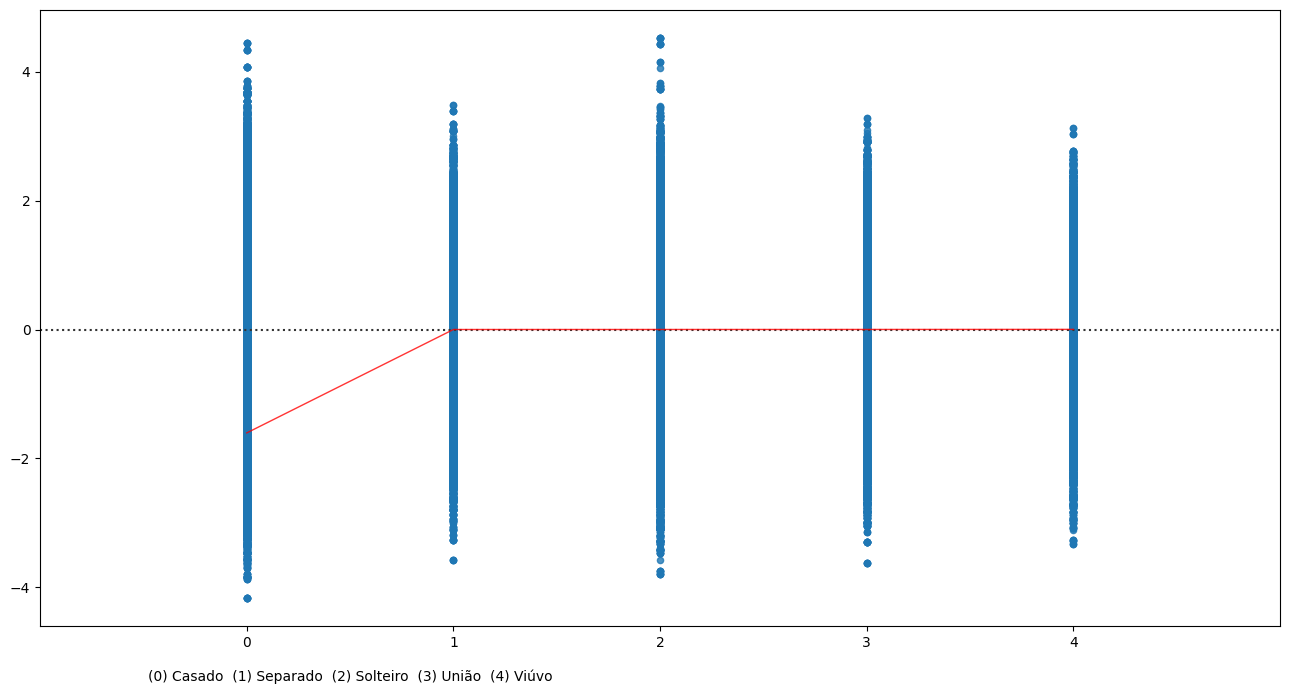

In [34]:
cat_residplot('estado_civil')

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Podemos verificar que existe influência do tipo "Casado" sobre os resíduos.
</div>

#### Tipo de residência

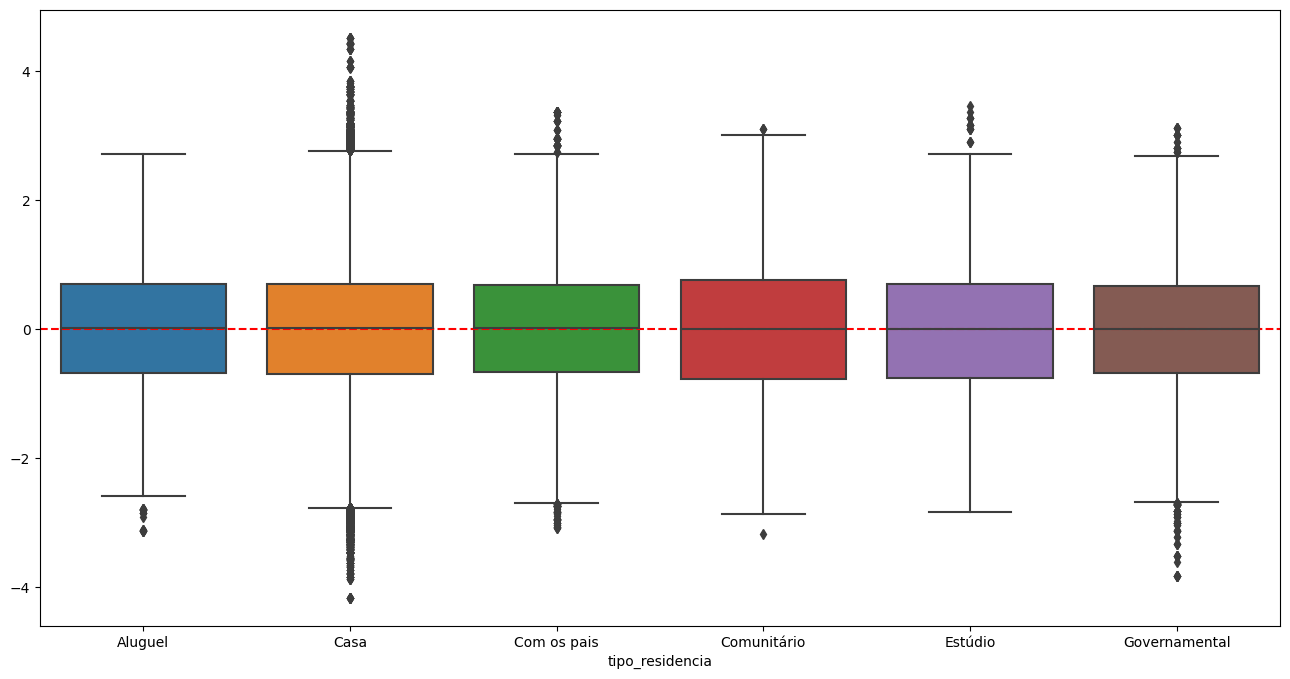

In [35]:
ax = sns.boxplot(data=df_treino, x="tipo_residencia", y=regsi.resid_studentized);
ax.axhline(y=0, color="red", linestyle='--');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A mediana dos resíduos está próxima de zero para todas as categorias, mas há variabilidade dos resíduos principalmente em "Comunitário" e "Estúdio". Também existem outliers em todas as categorias.
</div>

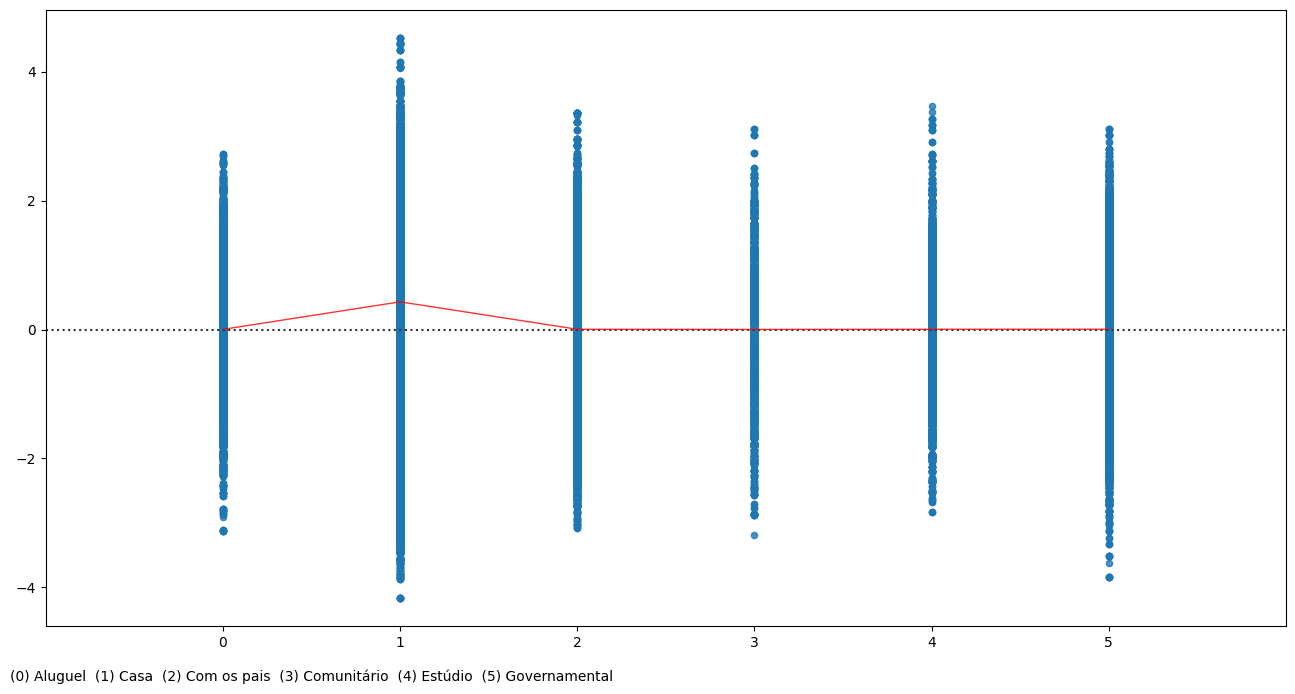

In [36]:
cat_residplot('tipo_residencia')

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Podemos verificar que existe influência do tipo "Casa" sobre os resíduos.
</div>

#### Tempo de emprego - Por intervalo de tempo

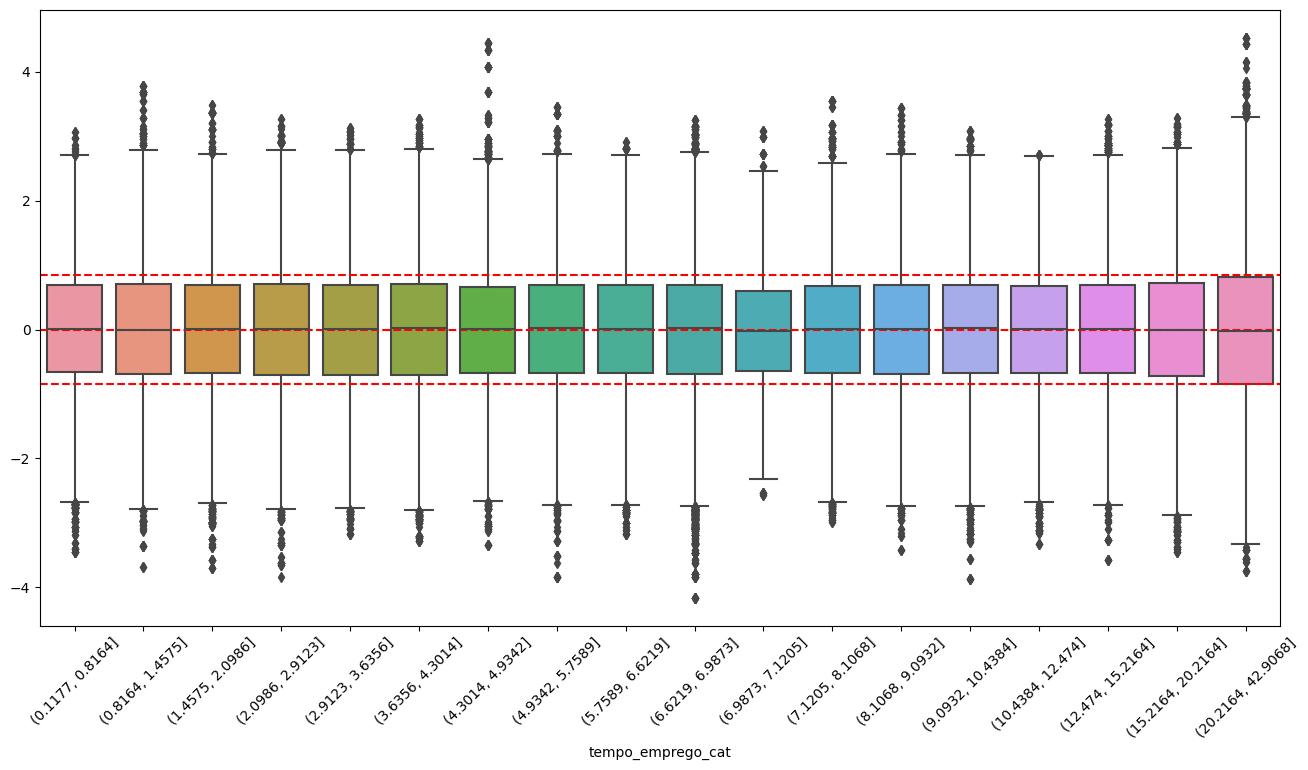

In [37]:
box = sns.boxplot(data=df_treino, x="tempo_emprego_cat", y=regsi.resid_studentized)
box.set_xticklabels(box.get_xticklabels(), rotation=45);
box.axhline(y=0, color="red", linestyle='--');
box.axhline(y=0.85, color="red", linestyle='--');
box.axhline(y=-0.85, color="red", linestyle='--');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A mediana dos resíduos está próxima de zero para todas as categorias, mas há variabilidade dos resíduos principalmente entre 6 e 7 anos e também, entre 20 e 42 anos. Aqui fica a impressão que categorizar o tempo de emprego em 20 quartis não foi adequado. Talvez o melhor seria criar os intervalos considerando a média do tempo mais 1 ou 2 DP.
</div>

### Avaliar se o valor médio dos resíduos aparenta ter relação com o mês de referência

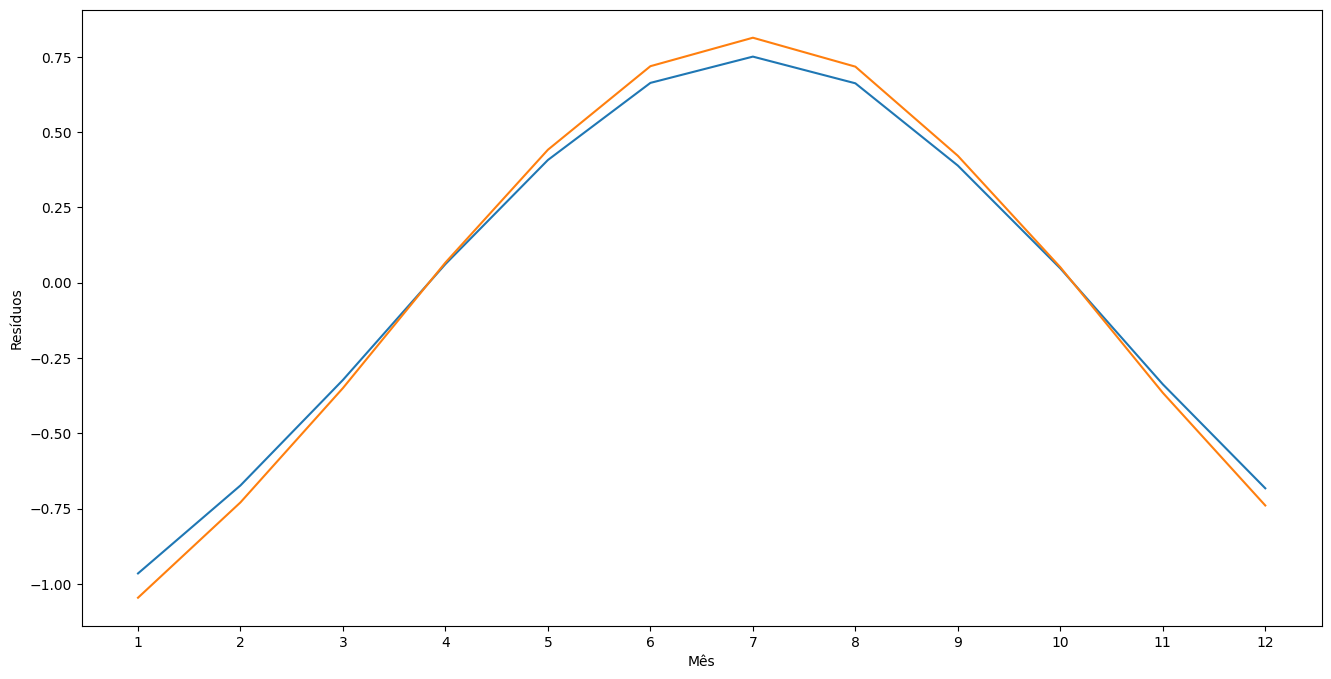

In [38]:
df_resid = df_treino.copy()
df_resid['resid'] = regsi.resid
df_resid['resid_studentized'] = regsi.resid_studentized

df_agrupado = df_resid.groupby([df_resid.data_ref.dt.month])[['resid', 'resid_studentized']].mean()
df_agrupado = df_agrupado.reset_index()
df_agrupado.rename(columns={'data_ref' : 'Mês', 'resid' : 'Resíduos'}, inplace=True)

axl = sns.lineplot(data=df_agrupado, x="Mês", y='Resíduos')
axl = sns.lineplot(data=df_agrupado, x="Mês", y='resid_studentized', ax=axl);
axl.set_xticks(range(1,13));

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Observando o gráfico acima, podemos dizer que os resíduos (normais e estudentizados) possuem sim uma relação com o mês de referência. 
    
Abaixo será feita uma análise do log da renda contra todas as variáveis do modelo para verificar o motivo dessa relação.
    
</div>

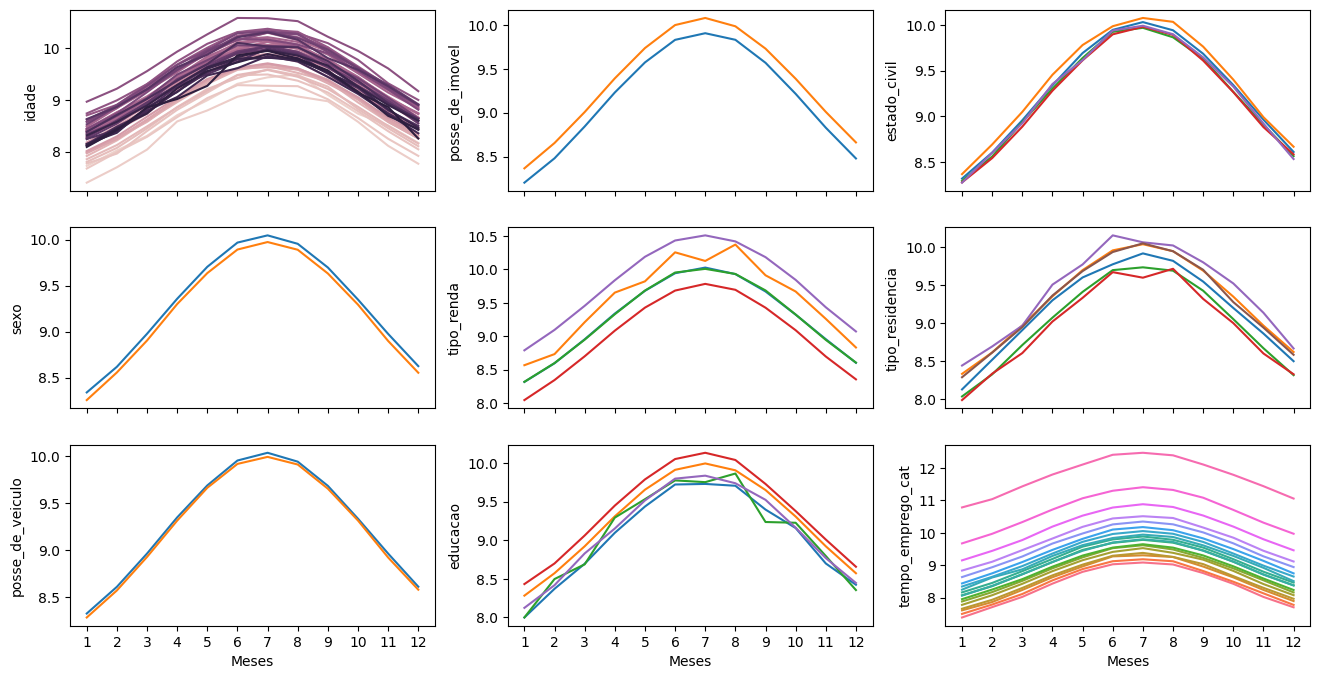

In [39]:
# variáveis do modelo
variaveis = [
    'idade',
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia',
    'tempo_emprego_cat',
]

# agrupa cada uma das variáveis pelo mês e calcula a média da renda pelo log
# o dicionário abaixo guarda o agrupamento de cada variável
grupos = {}
for n in variaveis:
    k = df_resid.groupby([df_resid.data_ref.dt.month, n])[['renda_log']].mean().reset_index()
    grupos[n] = k

# cria uma grade de gráficos 3 x 3
fig, axes = pyplt.subplots(3, 3, sharex=True)

# percorre os agrupamentos para exibir o gráfico de cada variável
c = 0; i = 0;
for n in grupos.keys():
    sns.lineplot(data=grupos[n], x="data_ref", y='renda_log', hue=n, ax=axes[c][i], legend=False);
    axes[c][i].set_xticks(range(1,13));
    axes[c][i].set(ylabel=n, xlabel='Meses')
    c += 1
    if c == 3:
        c = 0; i += 1;

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Podemos verificar no gráfico acima que o valor médio do log da renda possui relação com mês de referência em <b>todas</b> as variáveis. O padrão é o mesmo em todas elas: a renda tende a crescer até Junho, estabelece um topo até Agosto quanto tende a cair.
    
Como essa relação entre o mês, renda e resíduos se da em todas as variáveis, podemos imaginar que pode se tratar de uma <b>sazonalidade</b>.
    
</div>

### Avaliar se a variância da variável resposta parece ser conforme os valores previstos.

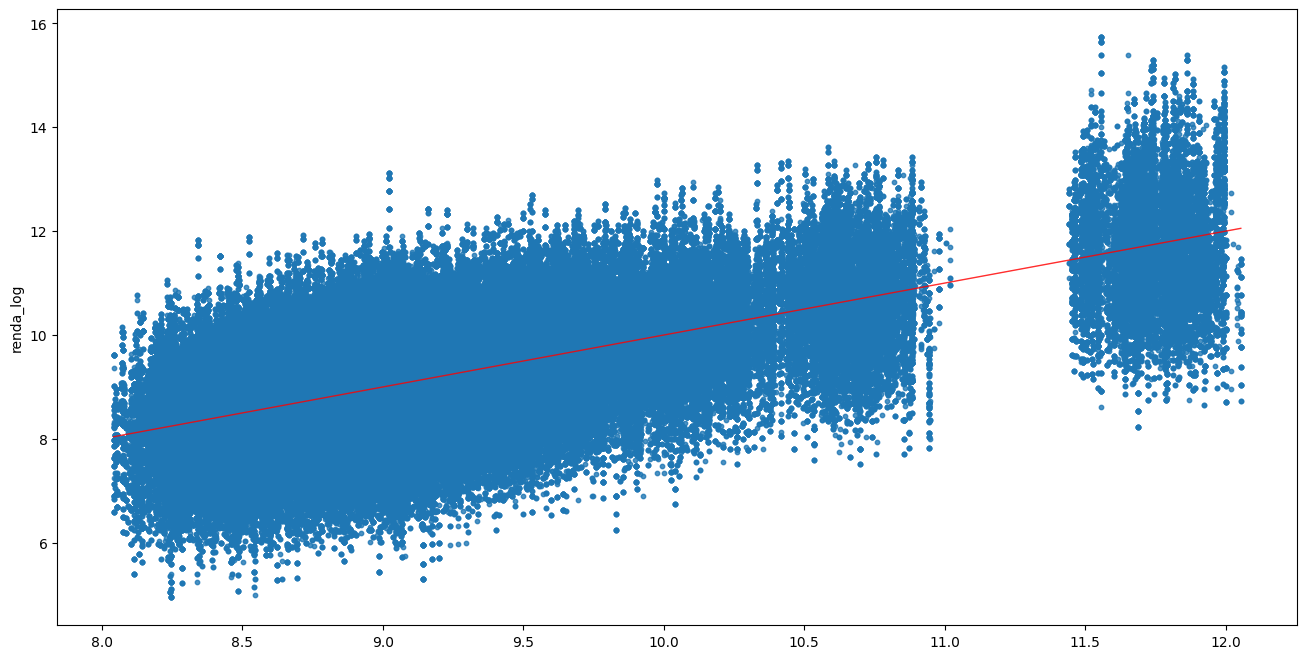

In [40]:
def regplot01():
    return sns.regplot(
        x=preditos, 
        y=df_treino['renda_log'], 
        scatter_kws={'alpha': 0.8, 's': 10}, 
        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
    );
cache_function(regplot01, 'regplot01');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Os pontos parecem estar uniformemente dispersos ao redor da linha de regressão, o que pode indicar homocedasticidade. A relação entre os pontos e a linha de regressão parece ser linear, sem grandes desvios. Mas há outliers visíveis no gráfico e a linha de regressão poderia se ajustar melhor aos pontos.
    
</div>

### Suposições do modelo

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Não podemos considerar que todas as premissas foram atendidas. Nos gráficos anteriores foi possível observar dados considerados outliers além da avaliação dos resíduos contra os valores preditos, que não apresentaram homocedasticidade clara.
    
</div>

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

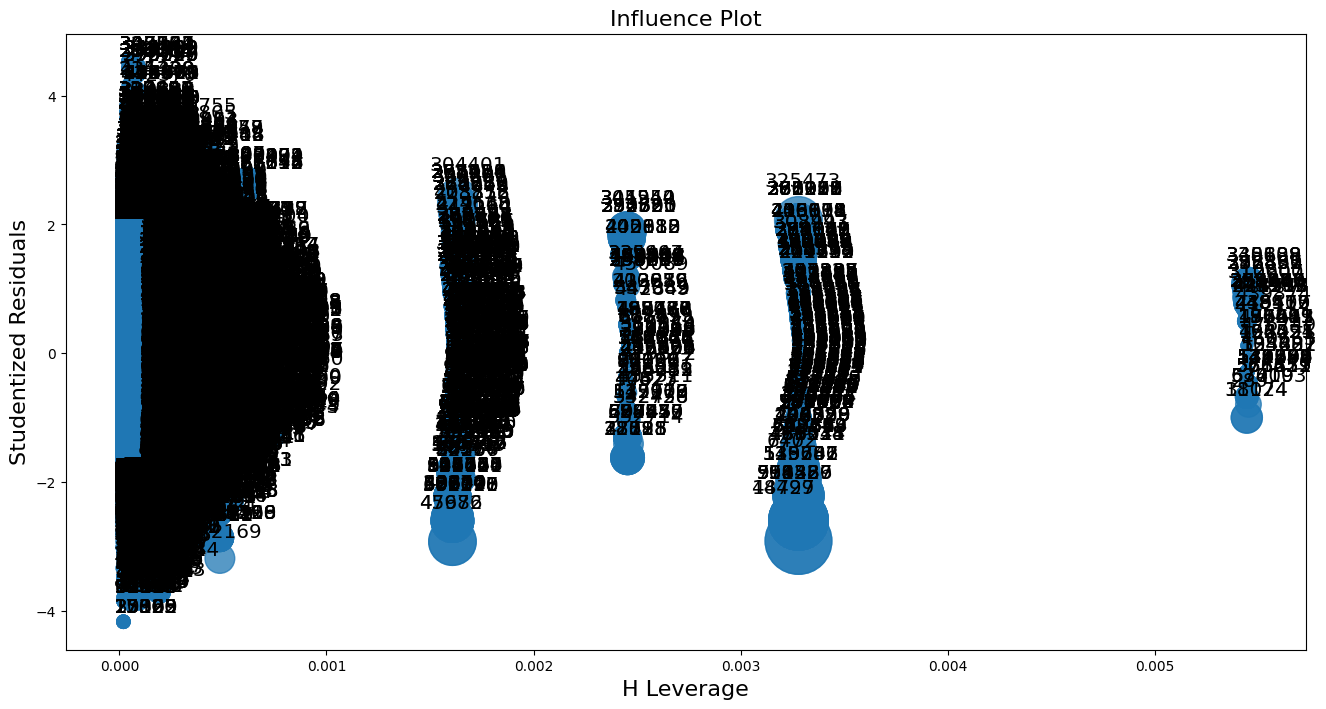

In [41]:
def plot_influence01():
    return regsi.plot_influence();
cache_function(plot_influence01, 'plot_influence01');

In [42]:
# função para retornar os índices dos pontos de influência com base no leverage
def recuperar_pontos_influencia(modelo, hleverage_inf = None, hleverage_sup = None):
    leve = []; stde = [];
    if hleverage_inf != None:
        leve = [i for i, k in enumerate(modelo.hat_matrix_diag) if k >= hleverage_inf]
    if hleverage_sup != None:
        stde = [i for i, k in enumerate(modelo.hat_matrix_diag) if k <= hleverage_sup]
    if hleverage_inf != None and hleverage_sup != None:
        conjunto_a = set(leve)
        conjunto_b = set(stde)
        return list(conjunto_a.intersection(conjunto_b))
    if hleverage_inf != None:
        return leve
    if hleverage_sup != None:
        return stde

In [43]:
# função que retorna os valores distintos de cada coluna do DataFrame passado por parâmetro
def verificar_valores_por_coluna(df_ref) -> pd.DataFrame:
    cl = list(df_ref.select_dtypes(include=['object', 'category', 'int64']).columns) + ['qt_pessoas_residencia']
    colunas_df = []; valores_df = [];
    for col in cl:
        valor_coluna = df_ref[col].unique()
        valor_coluna = map(lambda x: str(x), valor_coluna)
        valor_coluna = ", ".join(list(valor_coluna))
        colunas_df.append(col)
        valores_df.append(valor_coluna)

    return pd.DataFrame({'Coluna': colunas_df, 'Valores': valores_df})

#### Leverage >= 0.005

In [44]:
pontos01 = recuperar_pontos_influencia(regsi, 0.005)
df_outlier01 = df_treino.iloc[pontos01].copy()
len(df_outlier01)

72

In [45]:
verificar_valores_por_coluna(df_outlier01)

,Coluna,Valores
0,sexo,M
1,posse_de_veiculo,S
2,posse_de_imovel,N
3,qtd_filhos,2
4,tipo_renda,"Empresário, Assalariado"
5,educacao,"Médio, Superior completo"
6,estado_civil,Casado
7,tipo_residencia,Casa
8,idade,"39, 40"
9,tempo_emprego_cat,"(10.4384, 12.474], (5.7589, 6.6219]"


<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Temos 72 dados com leverage >= 0.005. Podemos ver na tabela acima que a diferença entre esses dados está centrada no tipo de renda, escolaridade e tempo de emprego. Destaco o tipo de renda: Empresário e Assalariado. Analisando em conjunto com a escolaridade e tempo de emprego, podemos concluir que um tem um nível de educação e tempo de emprego maior do que o outro.
    
</div>

#### Leverage >= 0.003 e <= 0.004

In [46]:
pontos02 = recuperar_pontos_influencia(regsi, 0.003, 0.004)
df_outlier02 = df_treino.iloc[pontos02].copy()
len(df_outlier02)

305

In [47]:
verificar_valores_por_coluna(df_outlier02)

,Coluna,Valores
0,sexo,F
1,posse_de_veiculo,N
2,posse_de_imovel,S
3,qtd_filhos,0
4,tipo_renda,Bolsista
5,educacao,Superior completo
6,estado_civil,Casado
7,tipo_residencia,Casa
8,idade,51
9,tempo_emprego_cat,"(10.4384, 12.474]"


<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Destaco que nesse conjunto de dados todas as variáveis são <b>iguais</b>. Destaco também o tipo de renda: Bolsista. Abaixo será feita uma análise apenas desse tipo de renda.
    
</div>

In [48]:
verificar_valores_por_coluna(df.query('tipo_renda == "Bolsista"'))

,Coluna,Valores
0,sexo,F
1,posse_de_veiculo,N
2,posse_de_imovel,S
3,qtd_filhos,0
4,tipo_renda,Bolsista
5,educacao,Superior completo
6,estado_civil,Casado
7,tipo_residencia,Casa
8,idade,51
9,tempo_emprego_cat,"(10.4384, 12.474]"


<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

A tabela acima exibe um compilado com todos os dados referentes aos registros com "tipo_renda" igual a "Bolsista". Podemos ver que na base de dados original, todos os dados dos bolsistas são iguais, variando apenas a renda. 
    
Acredito que esses dados poderiam ser excluídos por completo, tendo em vista que não seria possível prever a renda dessa categoria, sendo que todas as variáveis preditoras são iguais.


    
</div>

#### Leverage >= 0.002 e <= 0.003

In [49]:
pontos03 = recuperar_pontos_influencia(regsi, 0.002, 0.003)
df_outlier03 = df_treino.iloc[pontos03].copy()
len(df_outlier03)

116

In [50]:
verificar_valores_por_coluna(df_outlier03)

,Coluna,Valores
0,sexo,"F, M"
1,posse_de_veiculo,N
2,posse_de_imovel,"S, N"
3,qtd_filhos,1
4,tipo_renda,"Assalariado, Empresário"
5,educacao,"Superior completo, Médio"
6,estado_civil,"Casado, União"
7,tipo_residencia,Casa
8,idade,"33, 44, 34"
9,tempo_emprego_cat,"(2.0986, 2.9123], (3.6356, 4.3014], (5.7589, 6..."


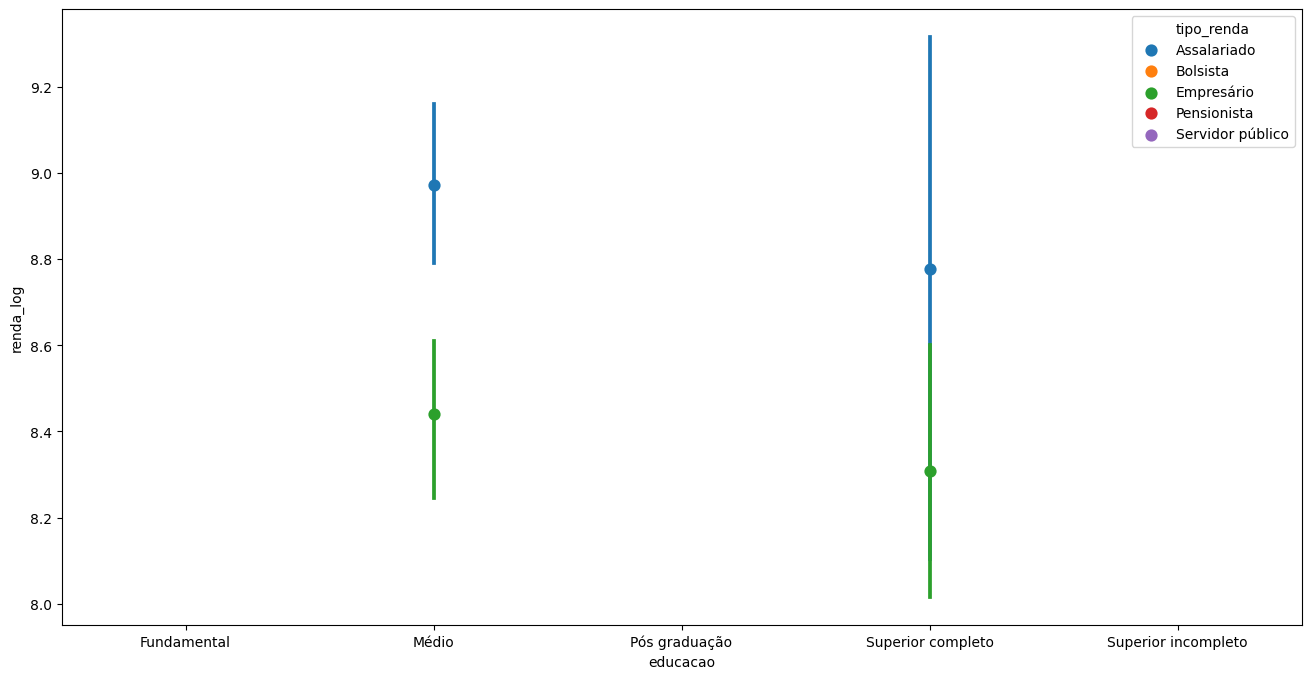

In [51]:
sns.pointplot(df_outlier03, x='educacao', y='renda_log', hue='tipo_renda');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Com os dados e o gráfico acima, podemos verificar que são dados onde o tipo renda "Empresário" possui uma renda inferior ao tipo renda "Assalariado" nos níveis de escolaridade "Superior completo" e "Médio"


    
</div>

#### Leverage >= 0.0015 e <= 0.002

In [52]:
pontos04 = recuperar_pontos_influencia(regsi, 0.0015, 0.0020)
df_outlier04 = df_treino.iloc[pontos04].copy()
len(df_outlier04)

630

In [53]:
verificar_valores_por_coluna(df_outlier04)

,Coluna,Valores
0,sexo,"F, M"
1,posse_de_veiculo,"S, N"
2,posse_de_imovel,S
3,qtd_filhos,"1, 0"
4,tipo_renda,"Empresário, Assalariado"
5,educacao,Pós graduação
6,estado_civil,"Casado, Solteiro, União"
7,tipo_residencia,Casa
8,idade,"33, 34, 61, 47, 58"
9,tempo_emprego_cat,"(2.0986, 2.9123], (7.1205, 8.1068], (0.1177, 0..."


In [54]:
index_pos = df_treino.query('educacao == "Pós graduação"').index
pontos04.sort()
np.unique(pontos04 == index_pos)

array([ True])

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Podemos verificar acima que todos os registros dentro desse intervalo de Leverage correspondem a pessoas que possuem Pós graduação
    
</div>

#### Leverage >= 0.00075 e <= 0.0010

Esses pontos fazem parte do grupo de pontos que estão localizados a esquerda no gráfico, porém, abaixo serão analisados apenas os pontos que estão mais a direta desse grupo.



In [55]:
pontos05 = recuperar_pontos_influencia(regsi, 0.00075, 0.0010)
df_outlier05 = df_treino.iloc[pontos05].copy()
verificar_valores_por_coluna(df_outlier05)

,Coluna,Valores
0,sexo,M
1,posse_de_veiculo,S
2,posse_de_imovel,S
3,qtd_filhos,14
4,tipo_renda,Assalariado
5,educacao,"Médio, Superior completo"
6,estado_civil,Separado
7,tipo_residencia,Casa
8,idade,48
9,tempo_emprego_cat,"(4.3014, 4.9342]"


<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Chama atenção nesses pontos a quantidade de filhos: 14. Todos os outros dados desses pontos também são iguais. Abaixo será feita uma consulta em toda a base em busca todos os registros que possuem 14 filhos.
    
</div>

In [56]:
verificar_valores_por_coluna(df_treino.query('qtd_filhos == 14'))

,Coluna,Valores
0,sexo,M
1,posse_de_veiculo,S
2,posse_de_imovel,S
3,qtd_filhos,14
4,tipo_renda,Assalariado
5,educacao,"Médio, Superior completo"
6,estado_civil,Separado
7,tipo_residencia,Casa
8,idade,48
9,tempo_emprego_cat,"(4.3014, 4.9342]"


<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Como podemos observar na tabela acima, todos os registros com 14 filhos em toda a base são os mesmo pontos destacados anteriormente. Nesse caso também podemos considerar esses registros como outliers.
    
</div>

#### Studentized Residuals <= -4

In [57]:
pontos06 = [i for i, k in enumerate(regsi.resid_studentized) if k <= -4]
df_outlier06 = df_treino.loc[pontos06]
verificar_valores_por_coluna(df_outlier06)

,Coluna,Valores
0,sexo,M
1,posse_de_veiculo,S
2,posse_de_imovel,S
3,qtd_filhos,0
4,tipo_renda,Pensionista
5,educacao,Médio
6,estado_civil,Casado
7,tipo_residencia,Casa
8,idade,56
9,tempo_emprego_cat,"(6.6219, 6.9873]"


In [58]:
len(df_outlier06)

7

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Podemos verificar que todos os registros que possuem resíduo abaixo de -4 possuem os mesmos registros. São 7 registros de Pensionistas identicos.
    
</div>

#### Studentized Residuals >= 4

In [59]:
pontos07 = [i for i, k in enumerate(regsi.resid_studentized) if k >= 4]
df_outlier07 = df_treino.loc[pontos07]
verificar_valores_por_coluna(df_outlier07)

,Coluna,Valores
0,sexo,"F, M"
1,posse_de_veiculo,"N, S"
2,posse_de_imovel,"N, S"
3,qtd_filhos,"0, 4"
4,tipo_renda,Assalariado
5,educacao,"Médio, Superior completo"
6,estado_civil,"Solteiro, Casado"
7,tipo_residencia,Casa
8,idade,"56, 31"
9,tempo_emprego_cat,"(20.2164, 42.9068], (4.3014, 4.9342]"


In [60]:
len(df_outlier07)

36

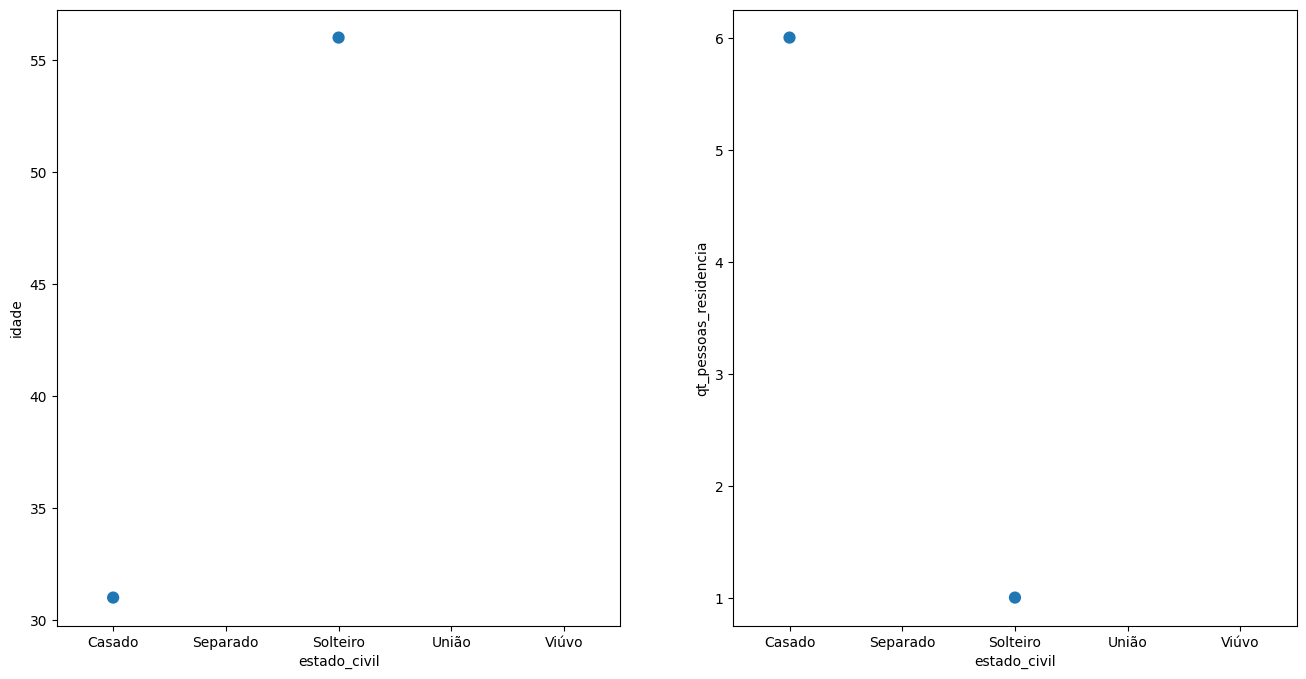

In [61]:
fig, axes = pyplt.subplots(1, 2)
sns.pointplot(df_outlier07, ax=axes[0], x='estado_civil', y='idade');
sns.pointplot(df_outlier07, ax=axes[1], x='estado_civil', y='qt_pessoas_residencia');

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Todos os registros que possuem resíduo acima de 4 possuem os mesmos registros. São 36 registros sendo que metade deles correspondentes a casados com 31 anos com 6 pessoas na residência e a outra metade são solteiros de 56 anos que moram sozinhos.
    
</div>

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

#### Matriz de Spearman

In [62]:
df_treino.corr(method='spearman', numeric_only=True).style.highlight_between(left=0.60, right=0.999)

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log
qtd_filhos,1.000000,-0.415384,-0.072721,0.828570,-0.020244,-0.020244
idade,-0.415384,1.000000,0.262357,-0.350081,0.113378,0.113378
tempo_emprego,-0.072721,0.262357,1.000000,-0.041976,0.537074,0.537074
qt_pessoas_residencia,0.828570,-0.350081,-0.041976,1.000000,-0.007401,-0.007401
renda,-0.020244,0.113378,0.537074,-0.007401,1.000000,1.000000
renda_log,-0.020244,0.113378,0.537074,-0.007401,1.000000,1.000000


#### V de Cramer

In [63]:
def cramers_corrected_stat(x, y):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher, 
    Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result = -1
    if len(x.value_counts()) == 1:
        print("First variable is constant")
    elif len(y.value_counts()) == 1:
        print("Second variable is constant")
    else:   
        conf_matrix = pd.crosstab(x, y)

        if conf_matrix.shape[0] == 2:
            correct=False
        else:
            correct=True

        chi2 = stats.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2 / n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
        return result

def cram(x, y, max_cat = 5):
    if (x.dtype in {np.dtype('float64'), np.dtype('int64')}) and (len(np.unique(x)) > max_cat):
        x_ = pd.qcut(x, max_cat)
    else: 
        x_ = x

    if (y.dtype in {np.dtype('float64'), np.dtype('int64')}) and (len(np.unique(y)) > max_cat):
        y_ = pd.qcut(y, max_cat)
    else: 
        y_ = y

    return cramers_corrected_stat(x_ ,y_)

def matriz_cramer(cdf, varis, max_cat = 5):
    matriz_cramer = pd.DataFrame(np.zeros((len(varis), len(varis))), columns=varis, index=varis)
    for var1 in varis:
        for var2 in varis:
            matriz_cramer.loc[var1, var2] = cram(cdf[var1], cdf[var2], max_cat)
    
    return matriz_cramer

In [64]:
variaveis_multi = [
    'sexo', 
    'posse_de_veiculo', 
    'posse_de_imovel', 
    'qtd_filhos', 
    'tipo_renda', 
    'educacao', 
    'estado_civil', 
    'tipo_residencia', 
    'idade', 
    'tempo_emprego_cat', 
    'qt_pessoas_residencia'
]

df_matriz = matriz_cramer(df_treino, variaveis_multi, 20)
df_matriz.style.highlight_between(left=0.60, right=0.999)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego_cat,qt_pessoas_residencia
sexo,1.000000,0.367391,0.055238,0.123566,0.190153,0.021655,0.170204,0.095631,0.228051,0.207523,0.162208
posse_de_veiculo,0.367391,1.000000,0.024697,0.121998,0.153018,0.099485,0.168568,0.051366,0.189052,0.165052,0.178204
posse_de_imovel,0.055238,0.024697,1.000000,0.032725,0.098883,0.056585,0.052602,0.211402,0.151578,0.109510,0.035722
qtd_filhos,0.123566,0.121998,0.032725,1.000000,0.138091,0.051146,0.101841,0.057683,0.197343,0.114028,0.943556
tipo_renda,0.190153,0.153018,0.098883,0.138091,1.000000,0.093570,0.106913,0.061139,0.384650,0.469354,0.129550
educacao,0.021655,0.099485,0.056585,0.051146,0.093570,1.000000,0.038727,0.050911,0.134703,0.095339,0.050715
estado_civil,0.170204,0.168568,0.052602,0.101841,0.106913,0.038727,1.000000,0.045531,0.167091,0.114542,0.445339
tipo_residencia,0.095631,0.051366,0.211402,0.057683,0.061139,0.050911,0.045531,1.000000,0.115962,0.100950,0.069224
idade,0.228051,0.189052,0.151578,0.197343,0.384650,0.134703,0.167091,0.115962,1.000000,0.198601,0.182429
tempo_emprego_cat,0.207523,0.165052,0.109510,0.114028,0.469354,0.095339,0.114542,0.100950,0.198601,1.000000,0.107695


#### VIF

In [65]:
df_vif = X.iloc[df_treino.index].copy()
df_vif.drop(columns=['Intercept'], inplace=True)

In [66]:
vars_vif = pd.DataFrame()
vars_vif['VIF Factor'] = [vif(df_vif, i) for i in range(df_vif.shape[1])]
vars_vif['Feature'] = df_vif.columns
vars_vif

,VIF Factor,Feature
0,1.827042,"C(sexo, Treatment('F'))[T.M]"
1,1.979371,"C(posse_de_veiculo, Treatment('N'))[T.S]"
2,1.591877,"C(posse_de_imovel, Treatment('S'))[T.N]"
3,1.013918,"C(tipo_renda, Treatment('Assalariado'))[T.Bols..."
4,1.480259,"C(tipo_renda, Treatment('Assalariado'))[T.Empr..."
5,8.655827,"C(tipo_renda, Treatment('Assalariado'))[T.Pens..."
6,1.210839,"C(tipo_renda, Treatment('Assalariado'))[T.Serv..."
7,1.031261,"C(educacao, Treatment('Médio'))[T.Fundamental]"
8,1.008974,"C(educacao, Treatment('Médio'))[T.Pós graduação]"
9,1.612417,"C(educacao, Treatment('Médio'))[T.Superior com..."


<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Existe uma forte relação entre as variáveis "qt_pessoas_residencia" e "qtd_filhos" de acordo com a **matriz de correlação de Spearman** e também com a estatística **V de Cramer**, 82% e 94%, respectivamente.
    
Essas duas variáveis também se destacam quando analisamos o VIF. Com relação ao VIF, também se destacam as variáveis idade e tempo de emprego entre 6.6219 e 6.9873 anos. Esse último pode ser explicado pela quantidade de registros dentro desse intervalo de tempo. Veja abaixo:
    
</div>

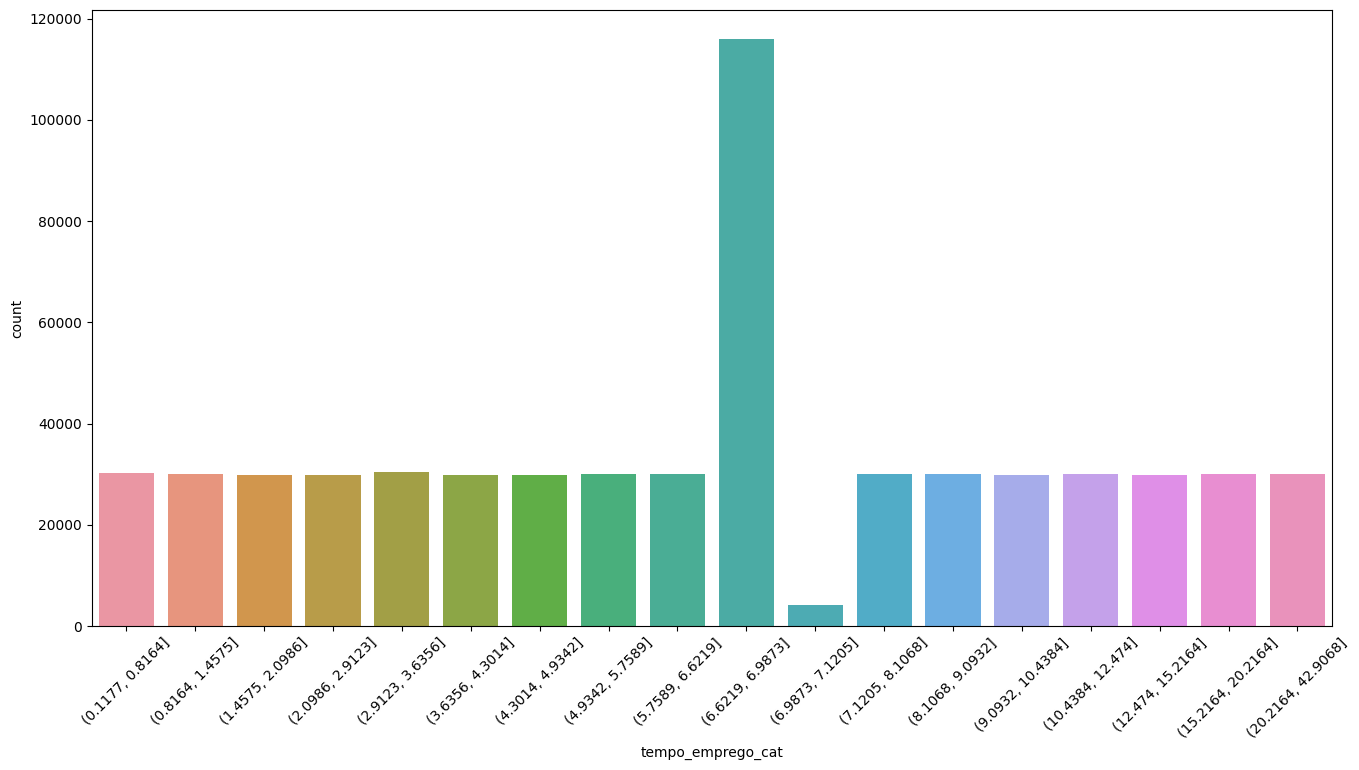

In [67]:
box_tempo = sns.countplot(df_treino, x='tempo_emprego_cat');
box_tempo.set_xticklabels(box_tempo.get_xticklabels(), rotation=45);

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">
    
Abaixo o VIF será recalculado excluindo as variáveis 'qt_pessoas_residencia' e 'qtd_filhos'
    
</div>

In [68]:
df_vif02 = X.iloc[df_treino.index].copy()
df_vif02.drop(columns=['Intercept', 'qt_pessoas_residencia', 'qtd_filhos'], inplace=True)

In [69]:
vars_vif02 = pd.DataFrame()
vars_vif02['VIF Factor'] = [vif(df_vif02, i) for i in range(df_vif02.shape[1])]
vars_vif02['Feature'] = df_vif02.columns
vars_vif02

,VIF Factor,Feature
0,1.780810,"C(sexo, Treatment('F'))[T.M]"
1,1.953200,"C(posse_de_veiculo, Treatment('N'))[T.S]"
2,1.555406,"C(posse_de_imovel, Treatment('S'))[T.N]"
3,1.013682,"C(tipo_renda, Treatment('Assalariado'))[T.Bols..."
4,1.459322,"C(tipo_renda, Treatment('Assalariado'))[T.Empr..."
5,8.361938,"C(tipo_renda, Treatment('Assalariado'))[T.Pens..."
6,1.205217,"C(tipo_renda, Treatment('Assalariado'))[T.Serv..."
7,1.030401,"C(educacao, Treatment('Médio'))[T.Fundamental]"
8,1.008309,"C(educacao, Treatment('Médio'))[T.Pós graduação]"
9,1.573519,"C(educacao, Treatment('Médio'))[T.Superior com..."


<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Removendo as variáveis 'qt_pessoas_residencia' e 'qtd_filhos', que também possuem forte relação segundo o V de Cramer, o maior VIF passa a ser a idade.
    
</div>

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [70]:
df_final_treino = df_treino.copy()
df_final_teste  = df_teste.copy()

# removendo os outliers encontrados anteriormente pelo gráfico de influência
df_final_treino.drop(df_outlier01.index, inplace=True)
df_final_treino.drop(df_outlier02.index, inplace=True)
df_final_treino.drop(df_outlier03.index, inplace=True)
df_final_treino.drop(df_outlier05.index, inplace=True)
df_final_treino.drop(df_outlier06.index, inplace=True)
df_final_treino.drop(df_outlier07.index, inplace=True)

# removendo outliers com 14 filhos!
drop_index = df_teste.query('qtd_filhos == 14').index
df_final_teste.drop(drop_index, inplace=True)

# removendo Bolsista
drop_index = df_teste.query('tipo_renda == "Bolsista"').index
df_final_teste.drop(drop_index, inplace=True)

drop_index = df_teste.query('educacao == "Pós graduação"').index
df_final_teste.drop(drop_index, inplace=True)

df_final_treino['tipo_renda'] = df_final_treino['tipo_renda'].cat.remove_unused_categories()
df_final_teste['tipo_renda']  =  df_final_teste['tipo_renda'].cat.remove_unused_categories()

df_final_treino['educacao'] = df_final_treino['educacao'].cat.remove_unused_categories()
df_final_teste['educacao']  =  df_final_teste['educacao'].cat.remove_unused_categories()

In [71]:
variaveis_modelo_final = [
    "C(sexo, Treatment('F'))",
    "C(posse_de_veiculo, Treatment('N'))",
    "C(posse_de_imovel, Treatment('S'))",
    "C(tipo_renda, Treatment('Assalariado'))",
    "C(educacao, Treatment('Médio'))",
    "C(estado_civil, Treatment('Casado'))",
    "C(tipo_residencia, Treatment('Casa'))",
    "idade",
    "tempo_emprego_faixa"
]

res_final = smf.ols(f"renda_log ~ {' + '.join(variaveis_modelo_final)}", data=df_final_treino).fit()
res_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                 1.184e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:59:07   Log-Likelihood:            -7.9781e+05
No. Observations:              599397   AIC:                         1.596e+06
Df Residuals:                  599357   BIC:                         1.596e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        8.2244      0.007   1144.858      0.000       8.210       8.238
C(sexo, Treatment('F'))[T.M]                                     0.1388      0.003     49.605      0.000       0.133       0.144
C(posse_de_veiculo, Treatment('N'))[T.S]                         0.0030      0.003      1.109      0.267      -0.002       0.008
C(posse_de_imovel, Treatment('S'))[T.N]                         -0.1887      0.003    -72.479      0.000      -0.194      -0.184
C(tipo_renda, Treatment('Assalariado'))[T.Empresário]            0.1414      0.003     47.097      0.000       0.136       0.147
C(tipo_renda, Treatment('Assalariado'))[T.Pensionista]           0.2716      0.003    105.653      0.000       0.267       0.277
C(tipo_renda, Treatment('Assalariado'))[T.Servidor público]      0.1331      0.004     30.057      0.000       0.124       0.142
C(educacao, Treatment('Médio'))[T.Fundamental]                  -0.0367      0.011     -3.265      0.001      -0.059      -0.015
C(educacao, Treatment('Médio'))[T.Pós graduação]                 0.0663      0.037      1.811      0.070      -0.005       0.138
C(educacao, Treatment('Médio'))[T.Superior completo]             0.0934      0.003     35.632      0.000       0.088       0.099
C(educacao, Treatment('Médio'))[T.Superior incompleto]           0.0164      0.006      2.627      0.009       0.004       0.029
C(estado_civil, Treatment('Casado'))[T.Separado]                 0.0226      0.005      4.317      0.000       0.012       0.033
C(estado_civil, Treatment('Casado'))[T.Solteiro]                 0.0090      0.004      2.416      0.016       0.002       0.016
C(estado_civil, Treatment('Casado'))[T.União]                    0.0102      0.005      2.256      0.024       0.001       0.019
C(estado_civil, Treatment('Casado'))[T.Viúvo]                    0.0096      0.006      1.561      0.119      -0.002       0.022
C(tipo_residencia, Treatment('Casa'))[T.Aluguel]                 0.0931      0.010      9.111      0.000       0.073       0.113
C(tipo_residencia, Treatment('Casa'))[T.Com os pais]             0.0374      0.006      6.299      0.000       0.026       0.049
C(tipo_residencia, Treatment('Casa'))[T.Comunitário]            -0.0508      0.018     -2.819      0.005      -0.086      -0.015
C(tipo_residencia, Treatment('Casa'))[T.Estúdio]                -0.0440      0.014     -3.137      0.002      -0.071      -0.017
C(tipo_residencia, Treatment('Casa'))[T.Governamental]          -0.0060      0.007     -0.867      0.386      -0.019       0.008
tempo_emprego_faixa[T.Interval(2.16, 4.32, closed='left')]       0.2964      0.004     69.883      0.000       0.288

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Após analise dos pontos de influencia, outliers e da multicolinearidade, o modelo final ficou com um R<sup>2</sup> ajustado de 0.435
    
</div>